# Combat Interactions Analyzer

for EVE online (www.eveonline.com) using game log files stored on local machine

crafted by Khlaa Sor of KS Endeavours (*work in progress, improvement suggestions welcome via in-game mail*)

In [30]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid") #  setting the visualization style
sns.set_context("notebook", font_scale=.9) # setting the visualization scale
import numpy as np
%matplotlib inline

In [31]:
# function to produce a list of explode values for pie charts
def pie_exploder(vals):
    """
    :vals: a list of values to be represented by the pie vedges, sorted in descending order for best results
    :return: a list of explode values for pie charts to only explode very narrow vedges
    :required: numpy
    """
    e = 0.01 # default explode value for all vedges
    explode = np.zeros(len(vals)) + e # generating default list of uniform explode values with numpy
    i = 0
    for val in vals:
        if val / sum(vals) < 0.03: #  tiny vedge qualification treshold (fraction of the total sum)
            explode[i] = e #  in the first run, default explode value is applied unchanged
            e += .09 #  incrementing the explode value starting from the second encountered tiny vedge
        i += 1

    return explode

## 1. Data selection and acquisition.

In [32]:
# Gamelogs directory path - unique for each user. CHANGE TO YOUR VALUE HERE
w_dir = 'D:\\Users\\misla\\Documents\\EVE\\logs\\Gamelogs\\'
w_dir = w_dir.replace('\\', '/')

# Building the list of log files potentially suitable for analysis
log_files = []
with os.scandir(w_dir) as all_files:
    for entry in all_files:
        if entry.stat().st_size > 512: # excluding very small files
            log_files.append(entry.name)

# Sorting the list of log files from newest down
log_files.sort(reverse=True)

# Looking for certain kind of targets
entity = input('Entity to search for (any part of name, Enter to skip): ')

if entity:
    traced = [] # list to hold file names where target of interest was detected
    for entry in log_files:
        path = w_dir + entry
        with open(path, encoding='utf-8') as file:
            if entity in file.read():
                traced.append(entry)

    if traced:
        log_files = traced
        print(f'{entity} traced in the following op logs ({len(log_files)}):')
    else:
        print('No traces detected.')    
else: 
    print('Not specified')
    print(f'Acquired the following log files ({len(log_files)}):')

Entity to search for (any part of name, Enter to skip):  


Not specified
Acquired the following log files (201):


In [33]:
for entry in log_files:
    print(entry)

20230216_132155_91278319.txt
20230215_123106_91278319.txt
20230214_050438_91278319.txt
20230213_055931_91278319.txt
20230210_113007_91278319.txt
20230208_113607_91278319.txt
20230208_033922_91278319.txt
20230207_131304_91278319.txt
20230206_181735_91278319.txt
20230206_121104_91278319.txt
20230205_183317_91278319.txt
20230201_162319_91674768.txt
20230128_182957_91278319.txt
20221225_042007_91278319.txt
20221224_111557_91278319.txt
20221224_100244_91278319.txt
20221224_052346_91278319.txt
20221223_111012_91278319.txt
20221223_100443_91278319.txt
20221223_033048_91278319.txt
20221222_142927_91278319.txt
20221222_115248_91278319.txt
20221215_130318_91278319.txt
20221214_170526_91278319.txt
20221214_051119_91278319.txt
20221214_045705_91278319.txt
20221213_171746_91278319.txt
20221213_160050_91278319.txt
20221212_121100_91278319.txt
20221211_135306_91278319.txt
20221210_054812_91278319.txt
20221209_120340_91278319.txt
20221209_102848_91278319.txt
20221209_041105_91278319.txt
20221208_12492

In [34]:
# Selecting the file to analyse
file_name = input('Log file name to analyze, Enter for latest: ')
if not file_name:
    file_name = log_files[0] # defaulting to the latest file

# Constructing the log file path
file_path = w_dir + file_name
print(file_path)

Log file name to analyze, Enter for latest:  


D:/Users/misla/Documents/EVE/logs/Gamelogs/20230216_132155_91278319.txt


In [35]:
# reading the file and getting rid of the tags in the process
with open(file_path) as log_file:
    lines = [re.sub('<.+?>', '', #  replacing each tag with empty string
                    line.strip() 
                   ) for line in log_file.readlines()]
if lines:
    print(f'Log data loaded: {len(lines)} entries')

Log data loaded: 2299 entries


In [36]:
# printing the log out line by line
for line in lines:
    print(line)

------------------------------------------------------------
Gamelog
Listener: Khlaa Sor
Session Started: 2023.02.16 13:21:55
------------------------------------------------------------
[ 2023.02.16 13:22:25 ] (question) 4 000 Skill Points will be redeemed and directly injected to Khlaa Sor.

Do you wish to proceed?
[ 2023.02.16 13:26:42 ] (None) Undocking from Toshabia VII - Freedom Extension Storage to Toshabia solar system.
[ 2023.02.16 13:27:34 ] (None) Jumping from Toshabia to Irnin
[ 2023.02.16 13:28:06 ] (None) Jumping from Irnin to Amarr
[ 2023.02.16 13:28:51 ] (notify) Setting course to docking perimeter
[ 2023.02.16 13:28:59 ] (hint) 1MN Y-S8 Compact Afterburner is already active
[ 2023.02.16 13:34:57 ] (None) Undocking from Amarr VIII (Oris) - Emperor Family Academy to Amarr solar system.
[ 2023.02.16 13:35:40 ] (None) Jumping from Amarr to Sarum Prime
[ 2023.02.16 13:36:32 ] (None) Jumping from Sarum Prime to Hama
[ 2023.02.16 13:37:19 ] (None) Jumping from Hama to Bagodan

In [37]:
lines[1] == 'Gamelog'

True

## 2. Preparing the data for analisys with Pandas.

In [38]:
# Getting a list of all combat related entries:
combat = [line.strip('[ ').replace(' ]', ''  # cleaning the timestamps
                                  ) for line in lines if '(combat)' in line]

if entity:
    specific = input('Filter for selected kind of targets (1/Enter):') 
    if specific:
        print(f'Filtering for {entity}')
        combat = [line for line in combat if entity in line]

# Getting a list of damage-exchange entries (by filtering misses, attempts and e-war interactions out)
# also replacing '(combat)' with '-' to use as a column separator
hits = [line.replace('(combat)', '-') for line in combat if (
    'misses' not in line) and (
    'attempt' not in line) and (
    'GJ energy' not in line) and (
    "jammed by" not in line)]
# !!! some (PC) entity designations can result in them not being accounted for
# hits

# and preparing it for dataframing by turning each entry into a row of cells
# installing column separators '-' and performing the split
hits = [line.replace(' to ', ' - to - ').replace(' from ', ' - from - ').split(' - ')  for line in hits] 
# inserting 'Unknown' for missing enemy weapon data
for entry in hits:
    if len(entry) != 6:
        entry.insert(-1, 'Unknown')

# Taking only dealt damage entries
# dealt = [entry for entry in hits if 'to' in entry]
# Creating the dealt damage dataframe
columns = ['Time', 'Damage', 'Direction', 'Entity', 'Weapon', 'Token']
# dealt_df = pd.DataFrame(data=dealt, columns=columns)

# dealt_df.Damage = dealt_df.Damage.astype('int')  # Casting the damage scores to integer

# Creating the damage exchange dataframe
hits_df =pd.DataFrame(data=hits, columns=columns)
hits_df.Damage = hits_df.Damage.astype('int')  # Casting the damage scores to integer

In [39]:
hits_df.describe(include='all')

,Time,Damage,Direction,Entity,Weapon,Token
count,1161,1161.000000,1161,1161,1161,1161
unique,558,NaN,2,26,5,6
top,2023.02.16 15:29:07,NaN,to,Sentry Gun,Federation Navy Hobgoblin,Hits
freq,51,NaN,821,149,757,412
mean,NaN,76.800172,NaN,NaN,NaN,NaN
std,NaN,70.310344,NaN,NaN,NaN,NaN
min,NaN,2.000000,NaN,NaN,NaN,NaN
25%,NaN,25.000000,NaN,NaN,NaN,NaN
50%,NaN,70.000000,NaN,NaN,NaN,NaN
75%,NaN,100.000000,NaN,NaN,NaN,NaN


### 2a. Other than HIts

- Energy
- Warp prevention
- Misses

In [40]:
non_hits = [line.replace('(combat)', '-') for line in combat if (
    'misses' in line) or (
    'attempt' in line) or (
    'GJ energy' in line) or (
    "jammed by" in line)]

non_hits

['2023.02.16 14:40:06 - Your Federation Navy Hobgoblin misses Sansha Light Missile Battery completely - Federation Navy Hobgoblin',
 '2023.02.16 14:40:18 - Tower Sentry Sansha I misses you completely',
 '2023.02.16 14:40:30 - Tower Sentry Sansha I misses you completely',
 '2023.02.16 14:40:35 - Tower Sentry Sansha I misses you completely',
 '2023.02.16 14:40:44 - Tower Sentry Sansha I misses you completely',
 '2023.02.16 14:40:46 - Tower Sentry Sansha I misses you completely',
 '2023.02.16 14:40:51 - Centii Scavenger misses you completely',
 '2023.02.16 14:40:54 - Centii Scavenger misses you completely',
 '2023.02.16 14:40:56 - Centii Scavenger misses you completely',
 '2023.02.16 14:40:59 - Centii Scavenger misses you completely',
 '2023.02.16 14:41:07 - Centii Slavehunter misses you completely',
 '2023.02.16 14:41:09 - Centii Slavehunter misses you completely',
 '2023.02.16 14:41:09 - Centii Savage misses you completely',
 '2023.02.16 14:41:10 - Centii Slavehunter misses you complete

In [41]:
len(hits + non_hits) == len(combat)

True

In [42]:
combat

['2023.02.16 14:40:05 (combat) 51 to Sansha Light Missile Battery - Federation Navy Hobgoblin - Grazes',
 '2023.02.16 14:40:06 (combat) 76 to Sansha Light Missile Battery - Federation Navy Hobgoblin - Hits',
 '2023.02.16 14:40:06 (combat) Your Federation Navy Hobgoblin misses Sansha Light Missile Battery completely - Federation Navy Hobgoblin',
 '2023.02.16 14:40:06 (combat) 66 to Sansha Light Missile Battery - Federation Navy Hobgoblin - Glances Off',
 '2023.02.16 14:40:09 (combat) 60 to Sansha Light Missile Battery - Federation Navy Hobgoblin - Glances Off',
 '2023.02.16 14:40:11 (combat) 104 to Sansha Light Missile Battery - Federation Navy Hobgoblin - Smashes',
 '2023.02.16 14:40:11 (combat) 90 to Sansha Light Missile Battery - Federation Navy Hobgoblin - Penetrates',
 '2023.02.16 14:40:11 (combat) 96 to Sansha Light Missile Battery - Federation Navy Hobgoblin - Smashes',
 '2023.02.16 14:40:12 (combat) 180 to Centii Minion - Mjolnir Light Missile - Hits',
 '2023.02.16 14:40:14 (com

#### - Warp Prevention

In [43]:
warp_prevention_df = pd.DataFrame(
    data=[line.replace("from", "-").replace("to", "-").replace('attempt ', '').rstrip('!').split(' - '
                                                        ) for line in non_hits if " - Warp " in line and " attempt " in line], 
    columns=['Time', 'Action', 'Issuer', 'Recipient']
)
warp_prevention_df

,Time,Action,Issuer,Recipient


In [44]:
received = warp_prevention_df[warp_prevention_df.Recipient == "you"].drop(columns = "Recipient")
received

for action in received.Action.unique():
    print(f" - {action} from {', '.join(received[received.Action == action].Issuer.unique().tolist())}")

#### - Energy War

- TO BE EXTENDED to cover all kinds of e-war interactions

In [45]:
ewar = [line.replace('GJ energy', '-').split(' - ') for line in non_hits if "energy" in line and "from" not in line]
for entry in ewar:
    pack = entry.pop(2).split(' ', 1)
    entry.insert(2, pack[0])
    entry.insert(3, pack[1])
    # print(entry[:-1])
    
ewar_df = pd.DataFrame(
    data = [entry[:-1] for entry in ewar], 
    columns = ["Time", "GJ", "Action", "Entity"]
)
ewar_df

for action in ewar_df.Action.unique():
    print(f" - {action} by {', '.join(ewar_df[ewar_df.Action == action].Entity.unique().tolist())}")

## 3. Analysing the data and displaying results

### 3.1. Summary Stats

In [46]:
# Dealt damage
dealt_df = hits_df.loc[hits_df.Direction == 'to']
targets = dealt_df.Entity.unique().tolist() 
print(f'Damage dealt to {len(targets)} kinds of targets:')
for target in targets:
    print(f' - {target}')
print()
weapons = dealt_df.Weapon.unique().tolist()
print(f'with {len(weapons)} types of weapon systems:')
for weapon in weapons:
    print(f' - {weapon}')
print()

# Incoming damage
incoming_df = hits_df.loc[hits_df.Direction == 'from']
enemies = incoming_df.Entity.unique().tolist() 
print(f'Damage taken from {len(enemies)} kinds of enemies:')
for enemy in enemies:
        print(f' - {enemy}')
print()
enemy_weapons = incoming_df.Weapon.unique().tolist()
print(f'with {len(enemy_weapons)} types of weapon systems:')
for enemy_weapon in enemy_weapons:
    print(f' - {enemy_weapon}')
print()

print("Enemy warp prevention acts:")
if not len(received):
    print("None")
for action in received.Action.unique():
    print(f" - {action} from {', '.join(received[received.Action == action].Issuer.unique().tolist())}")

print()    
print("Enemy energy war acts:")
if not len(ewar_df):
    print("None")
for action in ewar_df.Action.unique():
    print(f" - {action} by {', '.join(ewar_df[ewar_df.Action == action].Entity.unique().tolist())}")
    
print()

Damage dealt to 26 kinds of targets:
 - Sansha Light Missile Battery
 - Centii Minion
 - Centii Servant
 - Centii Scavenger
 - Tower Sentry Sansha I
 - Centii Slavehunter
 - Centii Savage
 - Centior Misshape
 - Centior Abomination
 - Centii Ravener
 - Centii Plague
 - Centior Devourer
 - Centior Cannibal
 - Centii Butcher
 - Centior Horror
 - Centior Monster
 - Centii Manslayer
 - Centii Enslaver
 - Centus Black Ops Agent
 - Sansha Black Ops Squad Leader
 - Centus Black Ops Assassin
 - Sentry Gun
 - Centus Black Ops Veteran
 - Centus Black Ops Commander
 - Sansha Heavy Missile Battery
 - Sansha Sentry Gun

with 3 types of weapon systems:
 - Federation Navy Hobgoblin
 - Mjolnir Light Missile
 - Scourge Fury Light Missile

Damage taken from 21 kinds of enemies:
 - Tower Sentry Sansha I
 - Centii Scavenger
 - Centii Slavehunter
 - Centii Savage
 - Centior Abomination
 - Sansha Light Missile Battery
 - Centii Plague
 - Centior Devourer
 - Centii Butcher
 - Centii Enslaver
 - Centii Manslay

#### 3.1.1. Dealt Damage

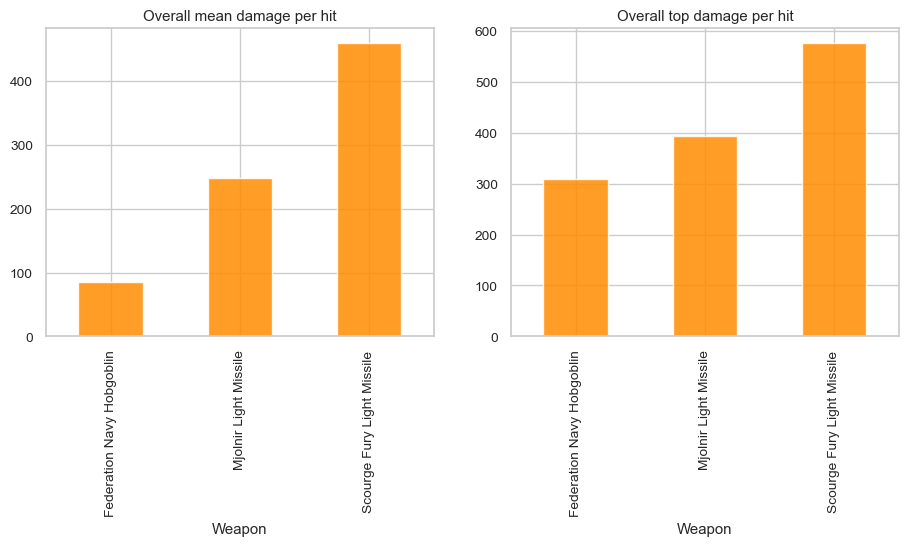

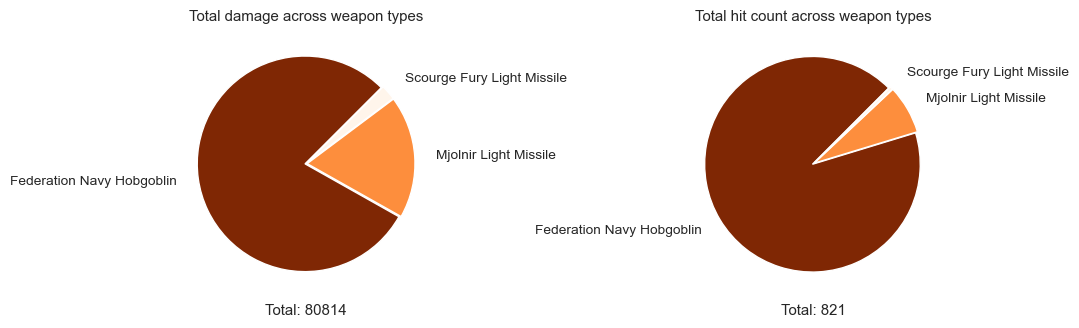

In [47]:
if weapons:
    # data for plotting
    means_per_weapon = dealt_df.groupby(['Weapon']).Damage.mean()#.sort_values(ascending=False)
    tops_per_weapon = dealt_df.groupby(['Weapon']).Damage.max()#.sort_values(ascending=False)
    totals_per_weapon = dealt_df.groupby(['Weapon']).Damage.sum().sort_values(ascending=False)
    hits_per_weapon = dealt_df.Weapon.value_counts()

    #  barcharts of mean and top damage scores per weapon
    plt.figure(figsize=(11,4)) 

    plt.subplot(121)
    means_per_weapon.plot(
        kind='bar', ylabel='', title='Overall mean damage per hit', 
        color='darkorange', alpha=.85
    )

    plt.subplot(122)
    tops_per_weapon.plot(
        kind='bar', ylabel='', title='Overall top damage per hit', 
        color='darkorange', alpha=.85
    )

    plt.show()

    # piecharts of total damage and hit counts per weapon
    plt.figure(figsize=(12,3.5), facecolor='white') 
    plt.subplot(121,
               xlabel=f'Total: {sum(totals_per_weapon)}') #  plotting total damage per weapon
    totals_per_weapon.plot(
        kind='pie', title='Total damage across weapon types', ylabel='',
        # radius=1.1,
        labeldistance=1.2,
        cmap='Oranges_r',
        startangle = 45,
        explode = pie_exploder(totals_per_weapon)
    )
    plt.subplot(122,
                xlabel=f'Total: {sum(hits_per_weapon)}') #  plotting total number of hits per weapon
    hits_per_weapon.plot(
        kind='pie', title='Total hit count across weapon types', ylabel='',
        # radius=.9,
        labeldistance=1.2,
        cmap='Oranges_r',
        startangle = 45,
        explode = pie_exploder(hits_per_weapon)
    )
    plt.show()
    
else:
    print('No meaningful interactions to analyze.')

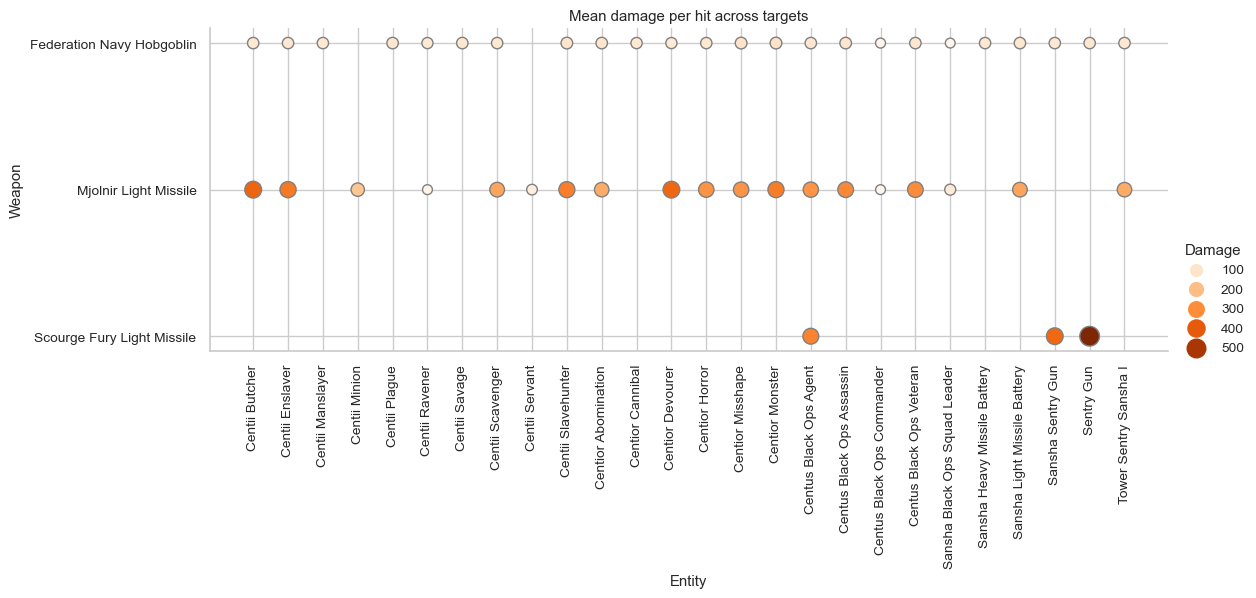

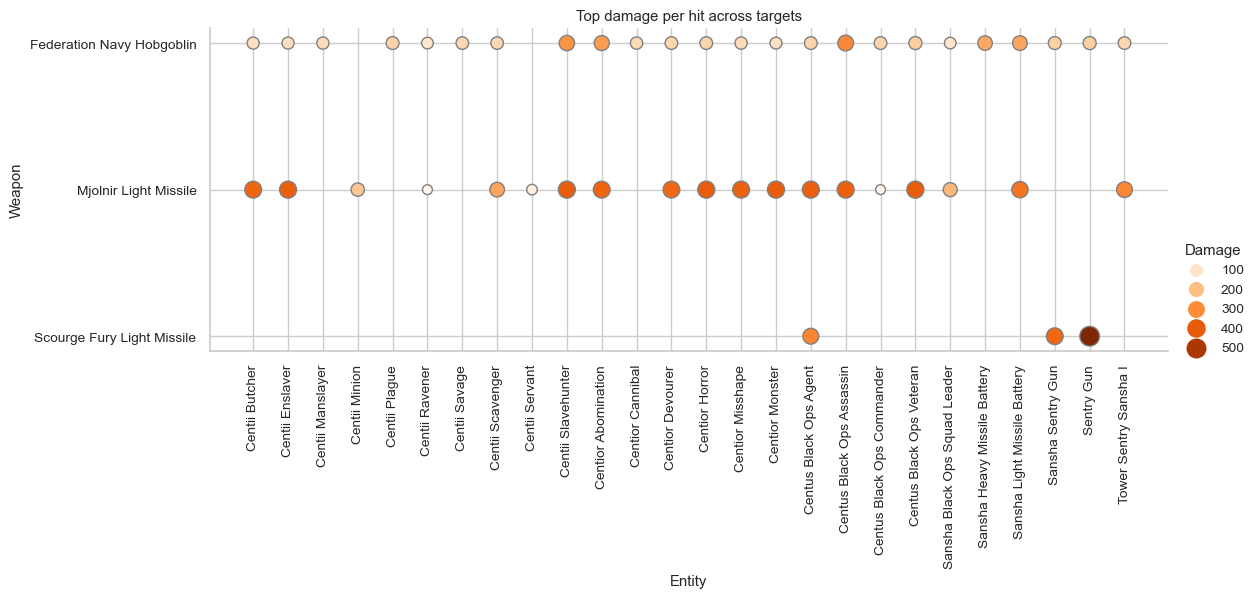

In [48]:
if weapons:
    # Plotting mean and top damage scores per weapon across all targets
    mean_damage_scores = pd.DataFrame(dealt_df.groupby(['Weapon', 'Entity']).Damage.mean()).sort_values(by='Entity').astype('int')
    top_damage_scores = pd.DataFrame(dealt_df.groupby(['Weapon', 'Entity']).Damage.max()).sort_values(by='Entity')

    # Mean damage
    sns.relplot(y="Weapon", x="Entity", hue="Damage", size='Damage',
                data=mean_damage_scores, 
                height=4, aspect=3, linewidth=1, edgecolor='gray',
                palette='Oranges', sizes=(50, 200)
        )
    plt.tick_params(axis='x', rotation=90)
    plt.title('Mean damage per hit across targets')
    plt.show()

    # Top damage
    sns.relplot(y="Weapon", x="Entity", hue="Damage", size='Damage',
                data=top_damage_scores, 
                height=4, aspect=3, linewidth=1, edgecolor='gray',
                palette='Oranges', sizes=(50, 200)
        )
    plt.tick_params(axis='x', rotation=90)
    plt.title('Top damage per hit across targets')
    plt.show()

Hit quality distributions per weapon


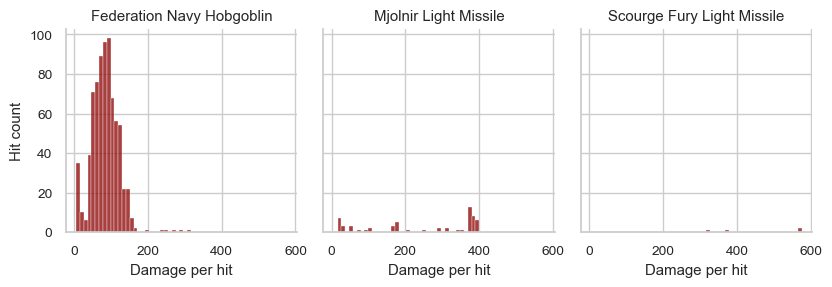

In [49]:
# Generating hit quality histograms with Seaborn
if weapons:
    print('Hit quality distributions per weapon')
    g = sns.displot(
        data=dealt_df, x="Damage", col="Weapon",
        col_wrap=5,
        height=3, aspect=.9, color='darkred'
    )
    g.set_axis_labels("Damage per hit", "Hit count")
    g.set_titles("{col_name}")
    plt.show()

**Alfa strike per weapon per target (top and bottom if much data):**

In [50]:
if weapons:
    if len(top_damage_scores) > 14:
        print(top_damage_scores.sort_values(by='Damage', ascending=False).head(7), end='\n'*2)
        print(top_damage_scores.sort_values(by='Damage', ascending=False).tail(7), end='\n'*2)
    else:
        print(top_damage_scores.sort_values(by='Damage', ascending=False), end='\n'*2)

                                                     Damage
Weapon                     Entity                          
Scourge Fury Light Missile Sentry Gun                   576
Mjolnir Light Missile      Centior Monster              394
                           Centus Black Ops Veteran     393
                           Centior Horror               393
                           Centii Slavehunter           393
                           Centii Enslaver              388
                           Centus Black Ops Agent       388

                                                         Damage
Weapon                    Entity                               
Federation Navy Hobgoblin Centii Enslaver                   117
                          Centior Monster                   111
                          Centii Ravener                     99
                          Sansha Black Ops Squad Leader      96
Mjolnir Light Missile     Centii Servant                     55
           

#### 3.1.2. Incoming Damage

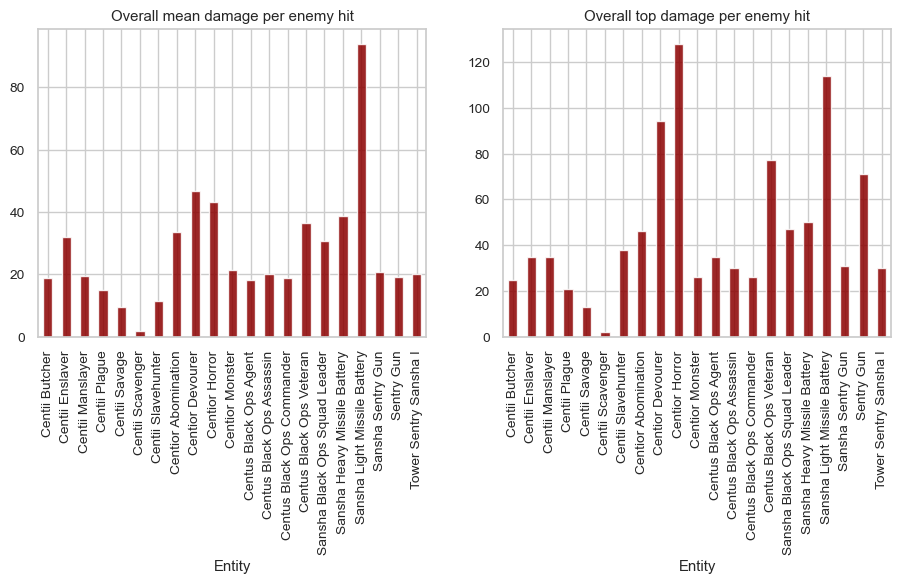

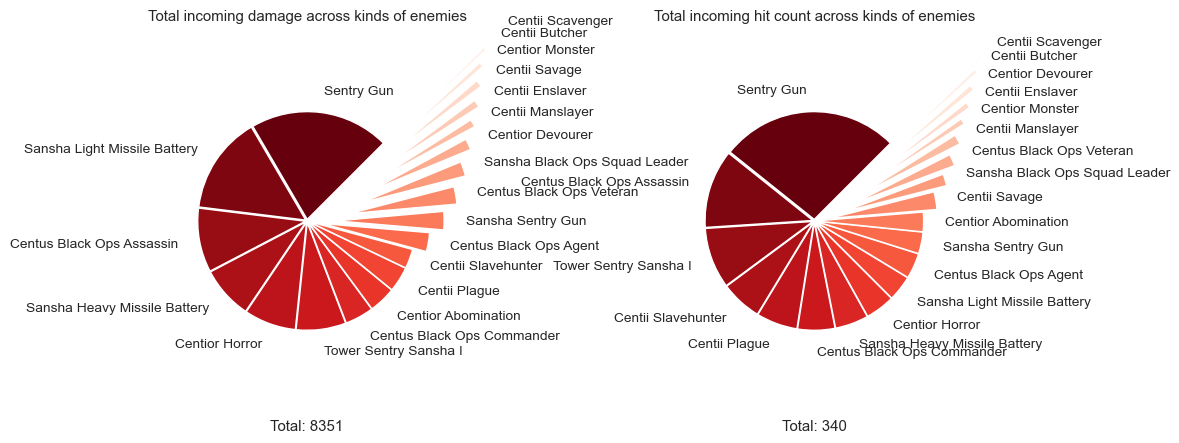

In [51]:
if enemies:
    # Data for plotting
    means_per_enemy = incoming_df.groupby(['Entity']).Damage.mean()
    tops_per_enemy = incoming_df.groupby(['Entity']).Damage.max()
    totals_per_enemy = incoming_df.groupby(['Entity']).Damage.sum().sort_values(ascending=False)
    hits_per_enemy = incoming_df.Entity.value_counts()
    
    #  barcharts of mean and top damage taken from each enemy
    plt.figure(figsize=(11,4)) 
    plt.subplot(121)
    means_per_enemy.plot(
        kind='bar', ylabel='', title='Overall mean damage per enemy hit', 
        color='darkred', alpha=.85
    )
    plt.subplot(122)
    tops_per_enemy.plot(
        kind='bar', ylabel='', title='Overall top damage per enemy hit', 
        color='darkred', alpha=.85
    )
    plt.show()
    
    # piecharts of total damage and hit counts from each enemy
    height = 3.5  # overall for the figure
    radius = 1  # for each pie
    if len(enemies) > 11: #  to provide more space for labels
        height = 5
        radius = .7
    
    plt.figure(figsize=(12,height), facecolor='white') 
    plt.subplot(121,
               xlabel=f'Total: {sum(totals_per_enemy)}')  # plotting total damage per enemy
    totals_per_enemy.plot(
        kind='pie', title='Total incoming damage across kinds of enemies', ylabel='',
        radius=radius,
        labeldistance=1.2,
        cmap='Reds_r',
        startangle = 45,
        explode = pie_exploder(totals_per_enemy)
    )
    plt.subplot(122,
                xlabel=f'Total: {sum(hits_per_enemy)}') #  plotting total number of hits per enemy
    hits_per_enemy.plot(
        kind='pie', title='Total incoming hit count across kinds of enemies', ylabel='',
        radius=radius,
        labeldistance=1.2,
        cmap='Reds_r',
        startangle = 45,
        explode = pie_exploder(hits_per_enemy)
    )
    plt.show()
    
else:
    print('No meaningful interactions to analyze.')

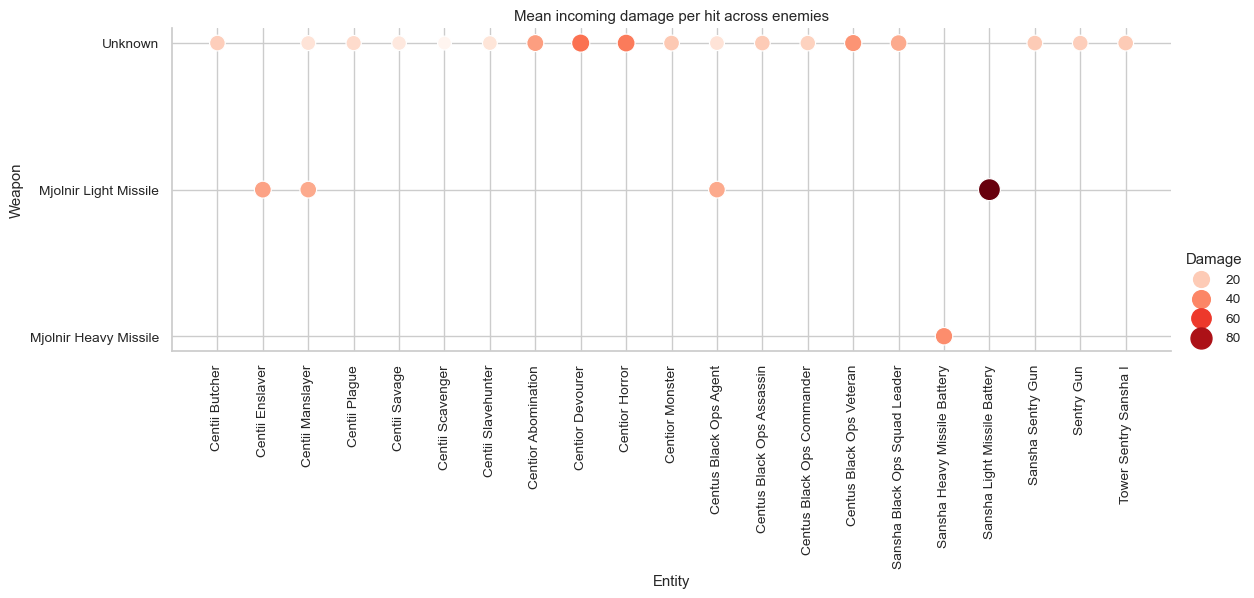

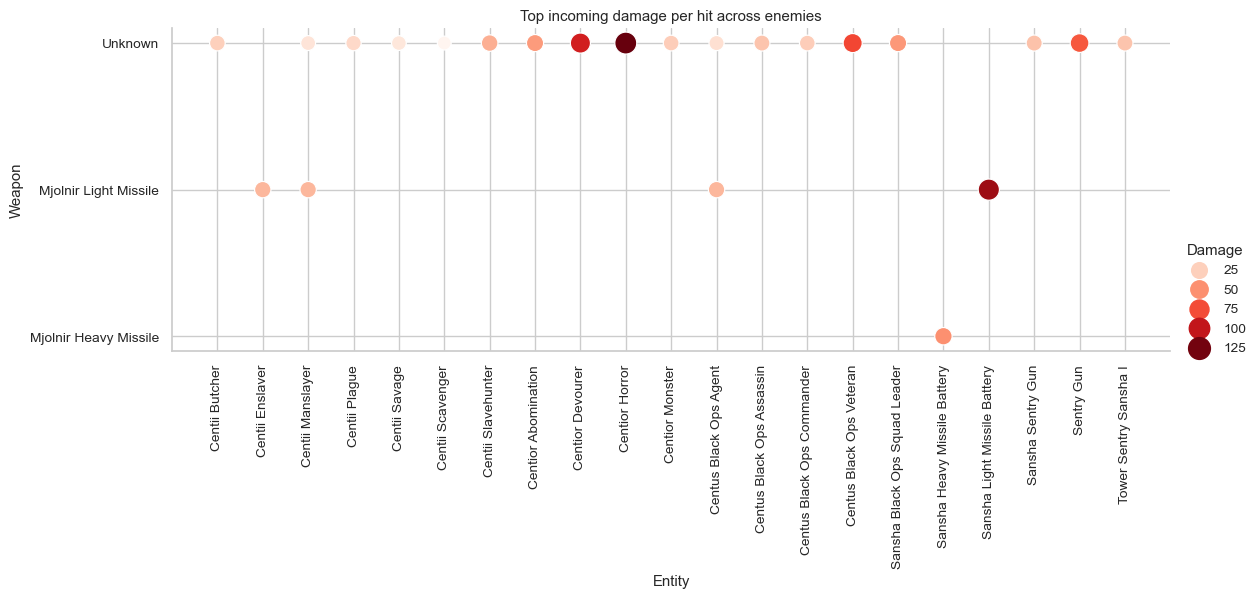

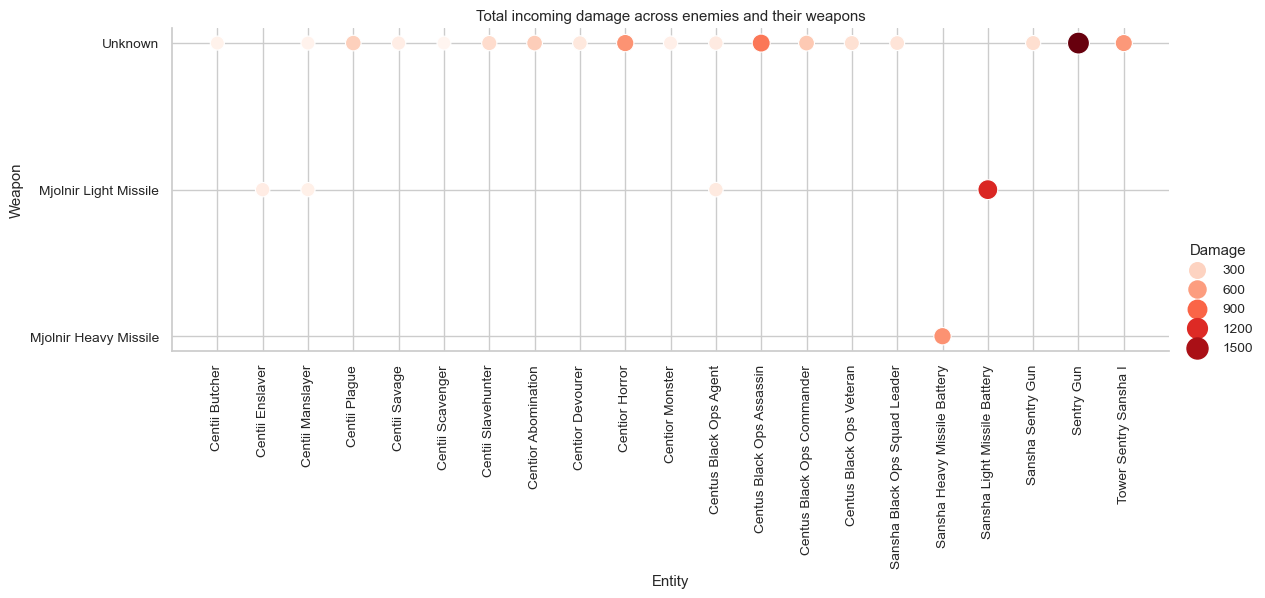

In [52]:
if len(enemy_weapons) > 1:
    # Plotting mean and top incoming damage scores per enemy weapon across all kinds of enemies
    mean_damage_scores = pd.DataFrame(incoming_df.groupby(['Weapon', 'Entity']).Damage.mean()).sort_values(by='Entity').astype(int)
    top_damage_scores = pd.DataFrame(incoming_df.groupby(['Weapon', 'Entity']).Damage.max()).sort_values(by='Entity')
    totals = pd.DataFrame(incoming_df.groupby(['Weapon', 'Entity']).Damage.sum()).sort_values(by='Entity')

    # Mean damage
    sns.relplot(y="Weapon", x="Entity", hue="Damage", size='Damage',
                data=mean_damage_scores, 
                height=4, aspect=3, 
                palette='Reds', sizes=(100, 250)
        )
    plt.tick_params(axis='x', rotation=90)
    plt.title('Mean incoming damage per hit across enemies')
    plt.show()

    # Top damage
    sns.relplot(y="Weapon", x="Entity", hue="Damage", size='Damage',
                data=top_damage_scores, 
                height=4, aspect=3, 
                palette='Reds', sizes=(100, 250)
        )
    plt.tick_params(axis='x', rotation=90)
    plt.title('Top incoming damage per hit across enemies')
    plt.show()
    
    # Total damage
    sns.relplot(y="Weapon", x="Entity", hue="Damage", size='Damage',
                data=totals, 
                height=4, aspect=3, 
                palette='Reds', sizes=(100, 250)
        )
    plt.tick_params(axis='x', rotation=90)
    plt.title('Total incoming damage across enemies and their weapons')
    plt.show()    

**Enemy alfa strike per weapon per kind of enemy (top 11):**

In [53]:
if enemy_weapons:
    print(top_damage_scores.sort_values(by='Damage', ascending=False).head(11), end='\n'*2)

                                                     Damage
Weapon                Entity                               
Unknown               Centior Horror                    128
Mjolnir Light Missile Sansha Light Missile Battery      114
Unknown               Centior Devourer                   94
                      Centus Black Ops Veteran           77
                      Sentry Gun                         71
Mjolnir Heavy Missile Sansha Heavy Missile Battery       50
Unknown               Sansha Black Ops Squad Leader      47
                      Centior Abomination                46
                      Centii Slavehunter                 38
Mjolnir Light Missile Centii Manslayer                   35
                      Centii Enslaver                    35



### 3.2. Weapons performance on each target


Performance on Sansha Light Missile Battery:



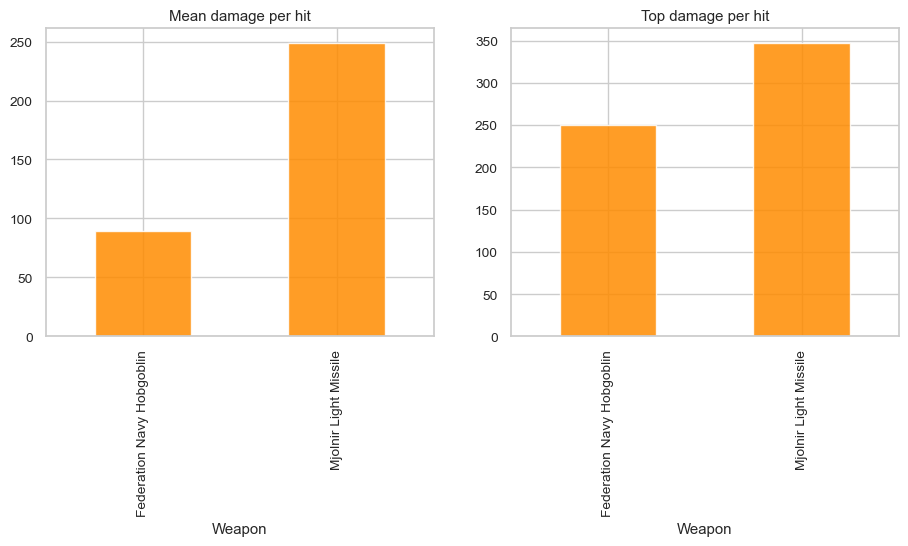

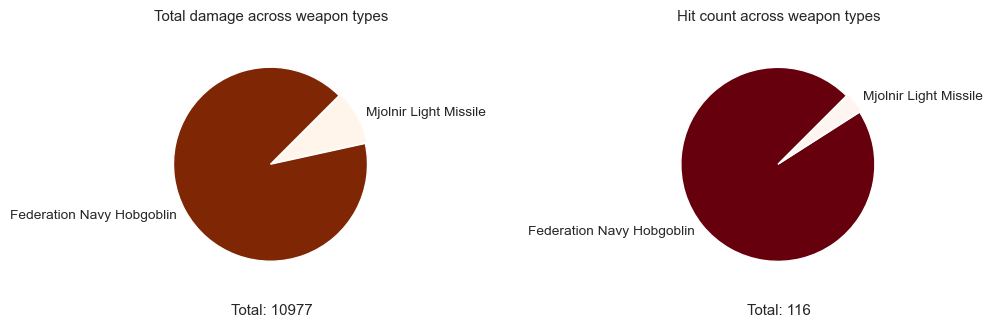

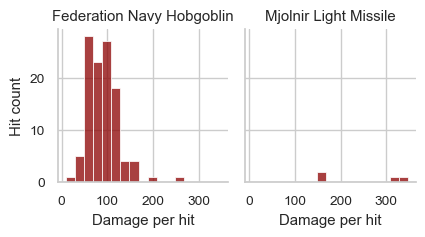



Performance on Centii Minion:



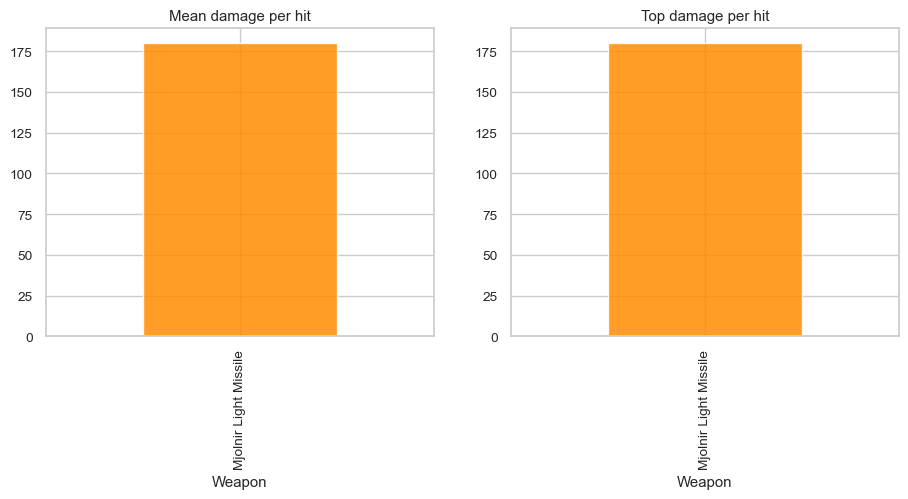

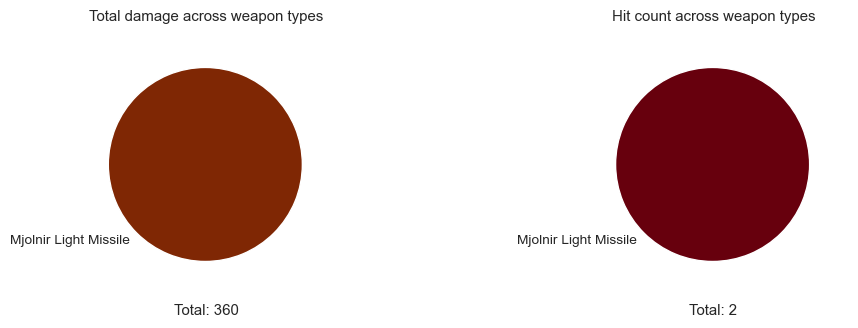

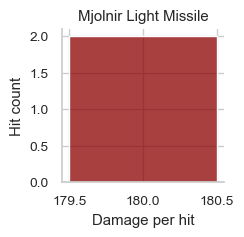



Performance on Centii Servant:



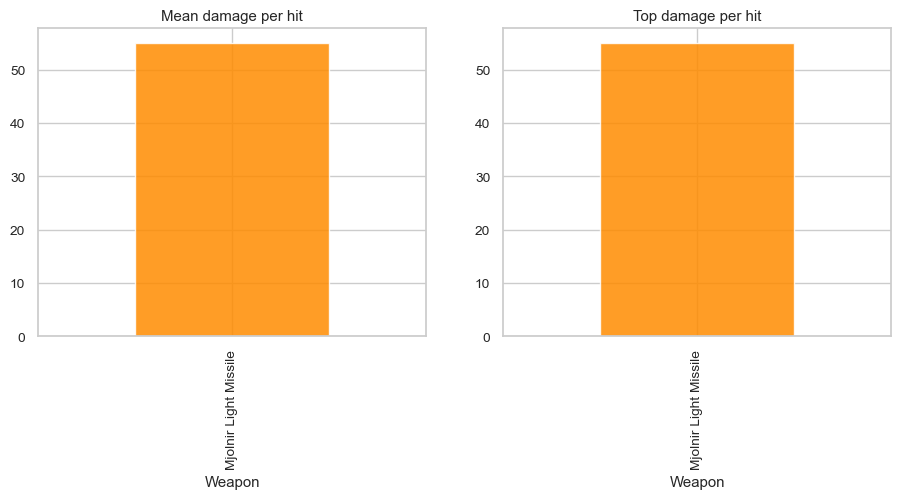

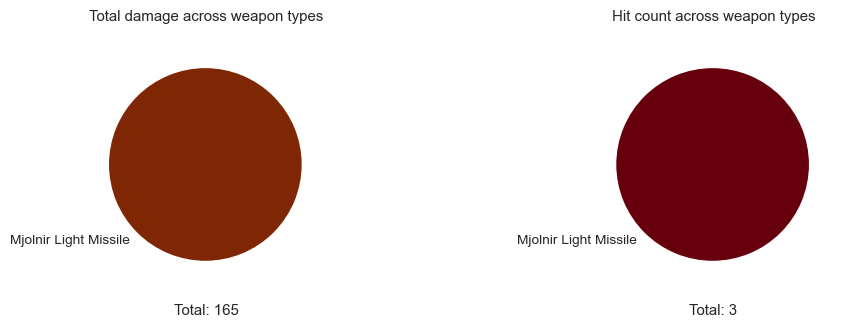

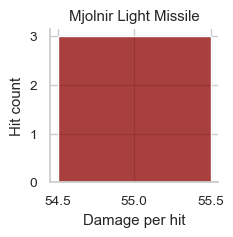



Performance on Centii Scavenger:



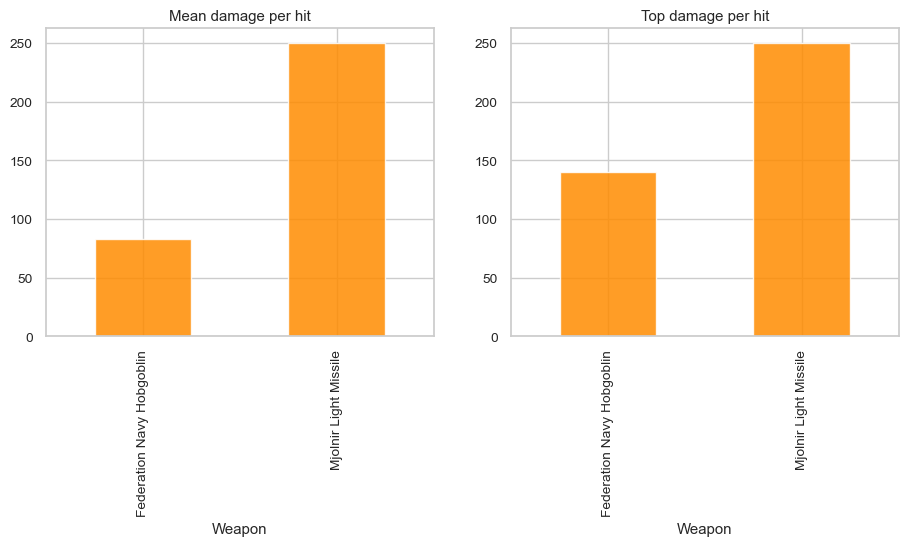

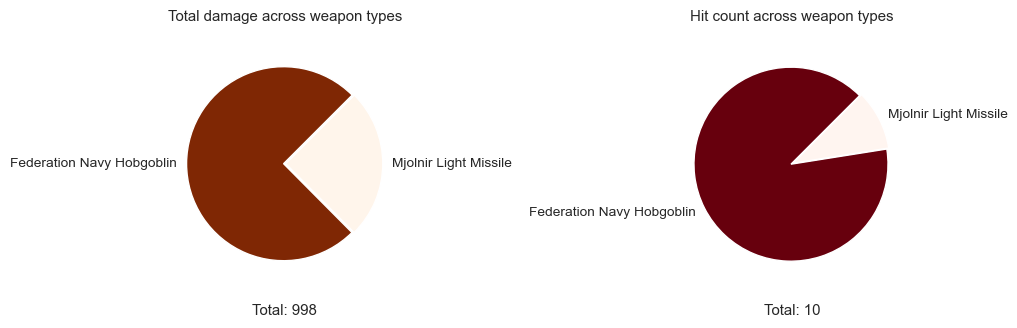

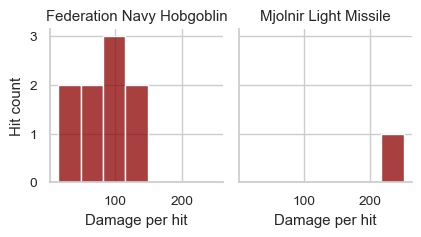



Performance on Tower Sentry Sansha I:



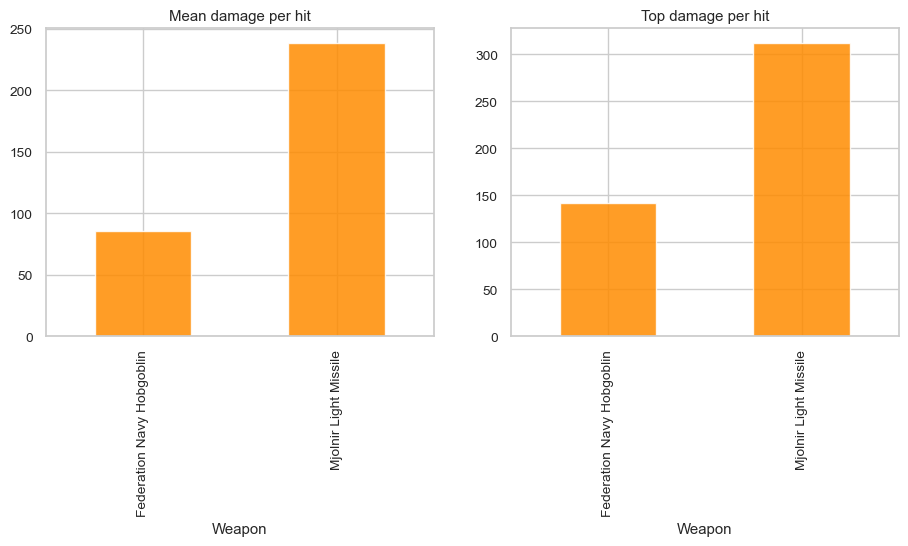

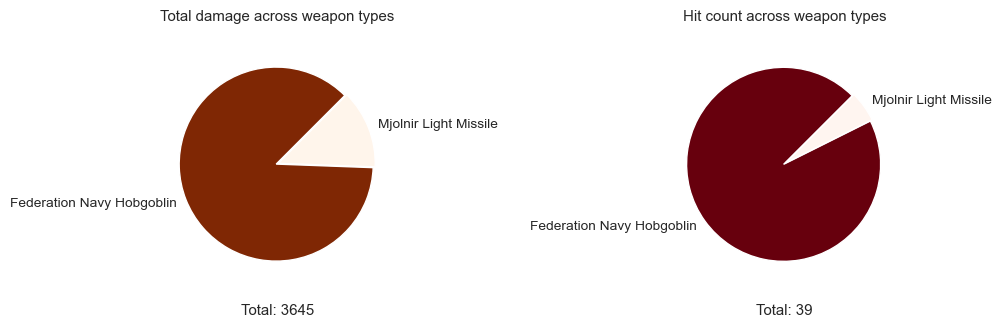

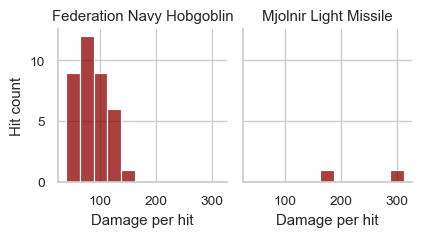



Performance on Centii Slavehunter:



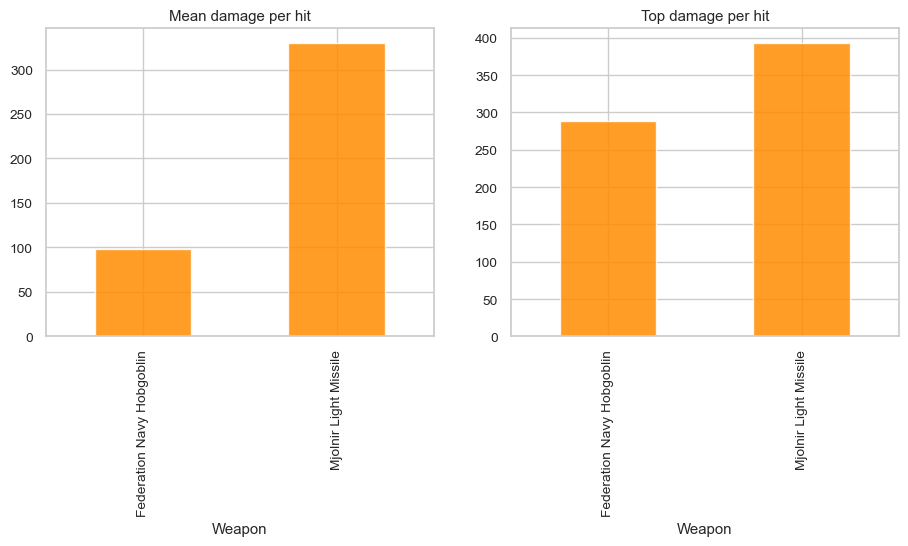

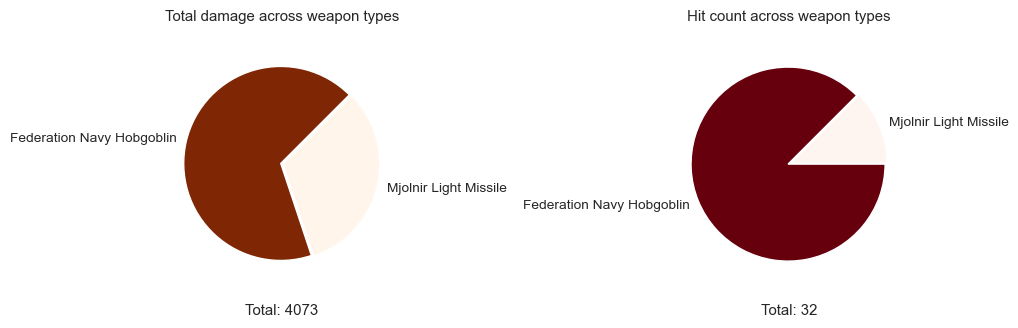

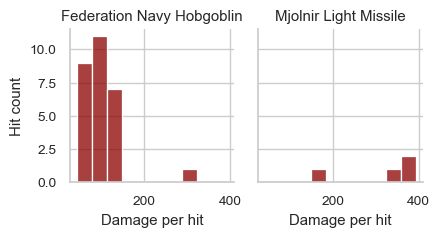



Performance on Centii Savage:



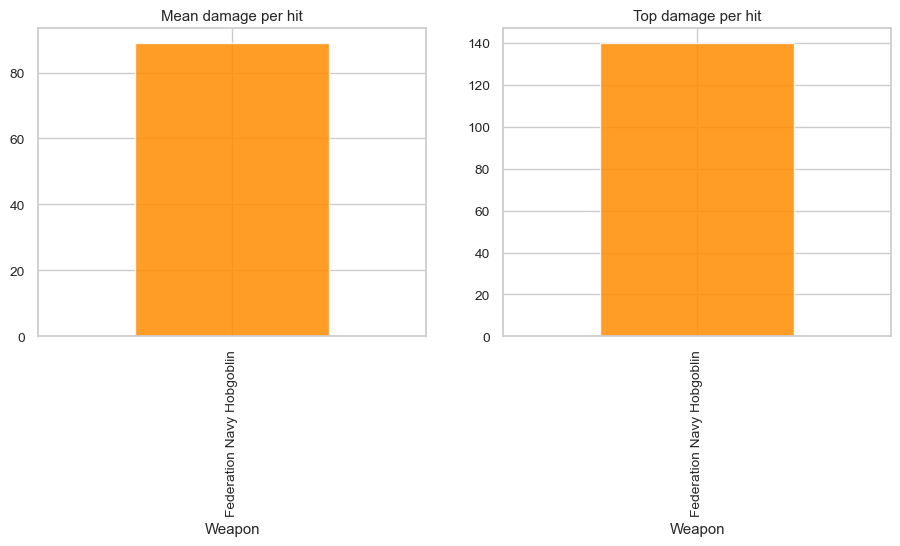

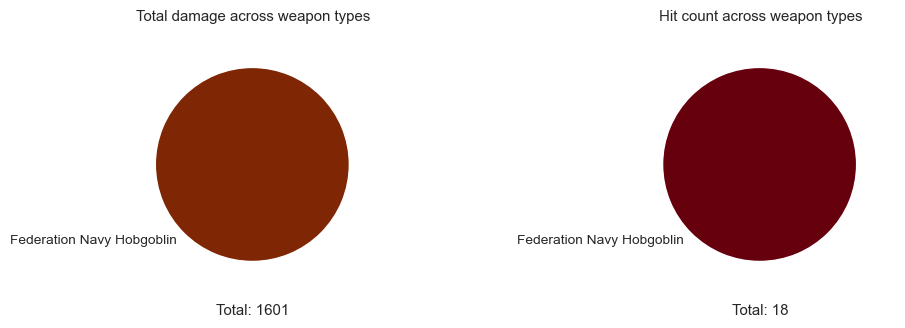

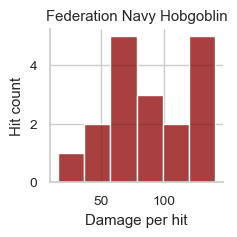



Performance on Centior Misshape:



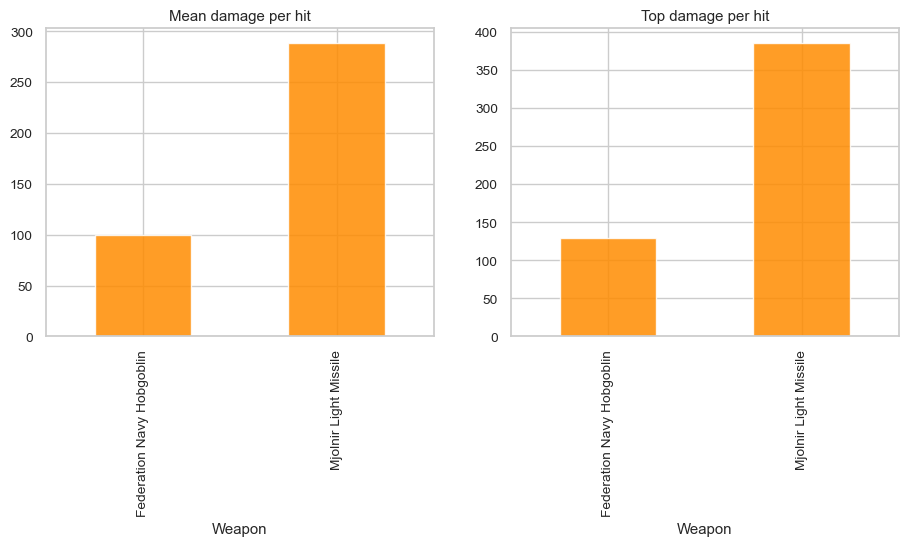

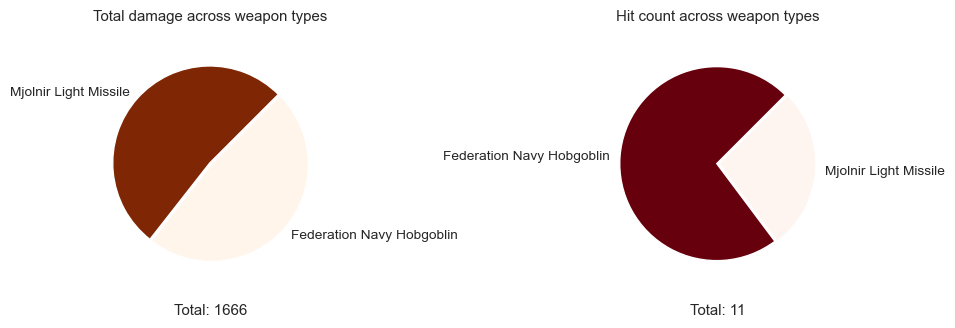

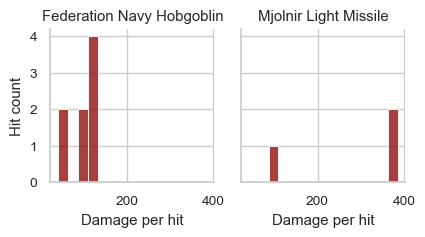



Performance on Centior Abomination:



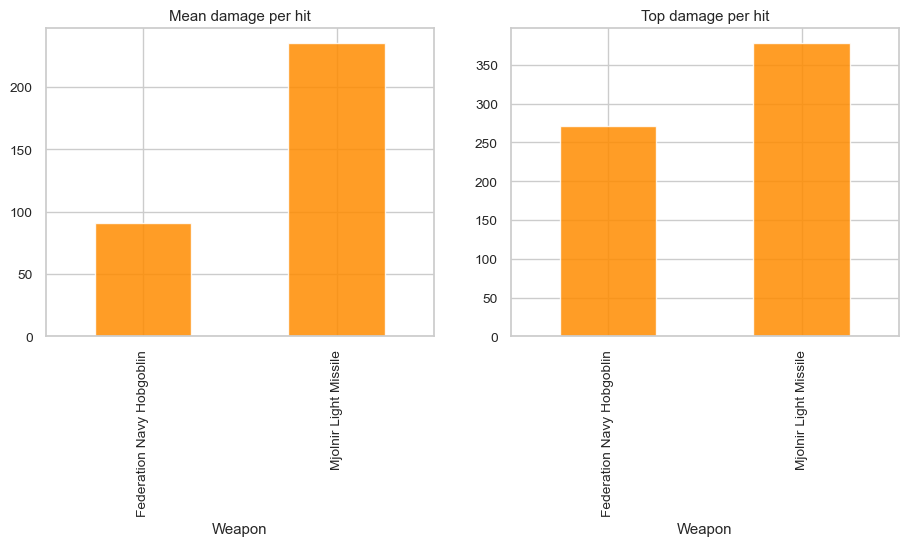

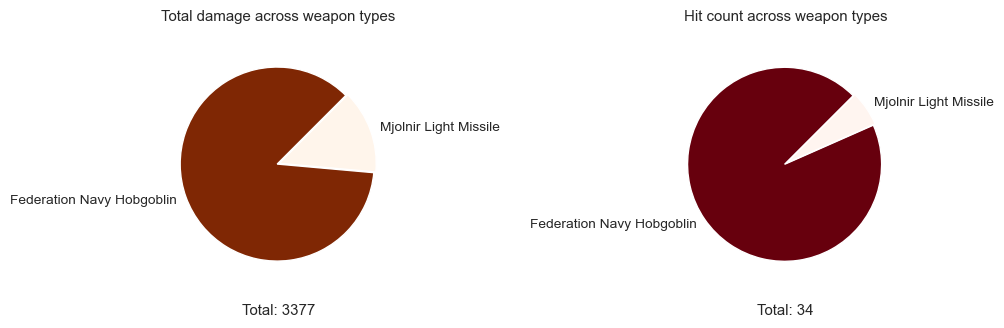

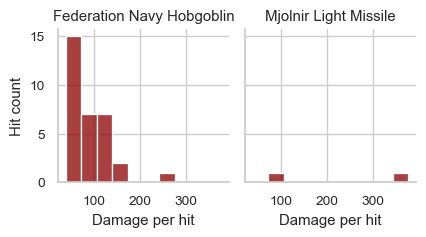



Performance on Centii Ravener:



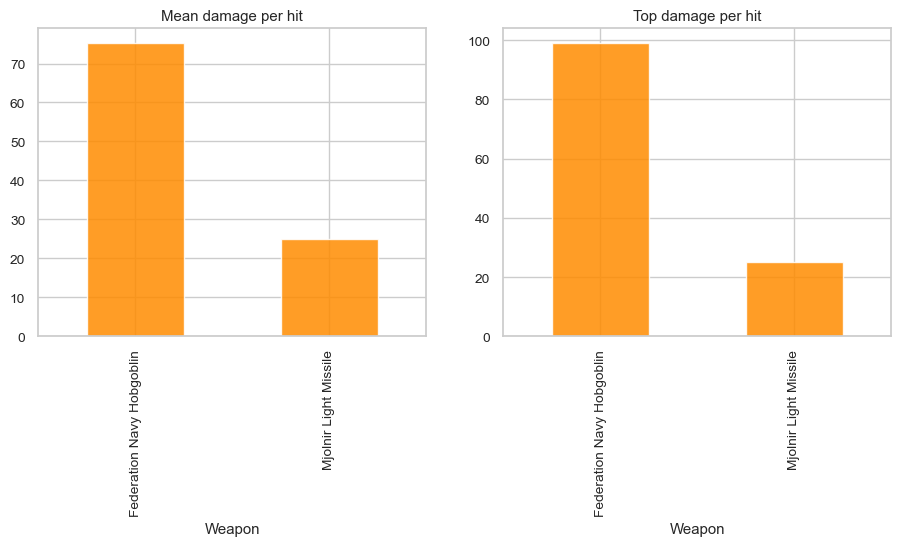

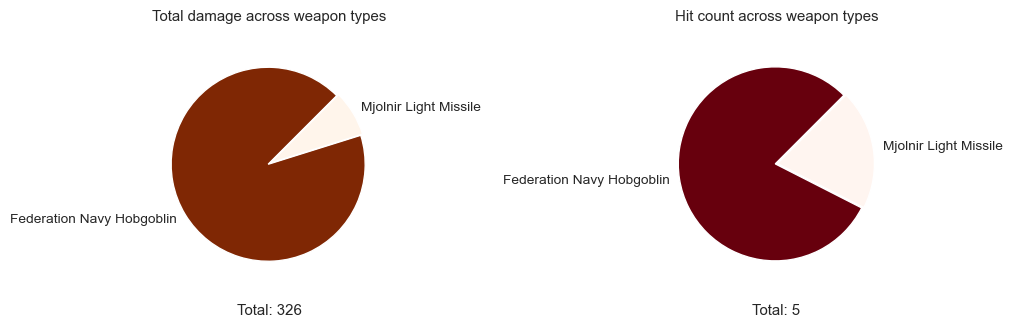

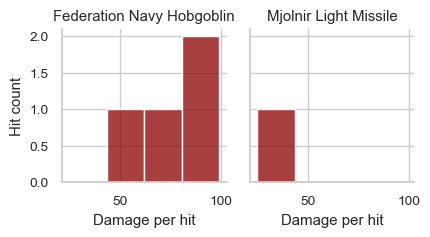



Performance on Centii Plague:



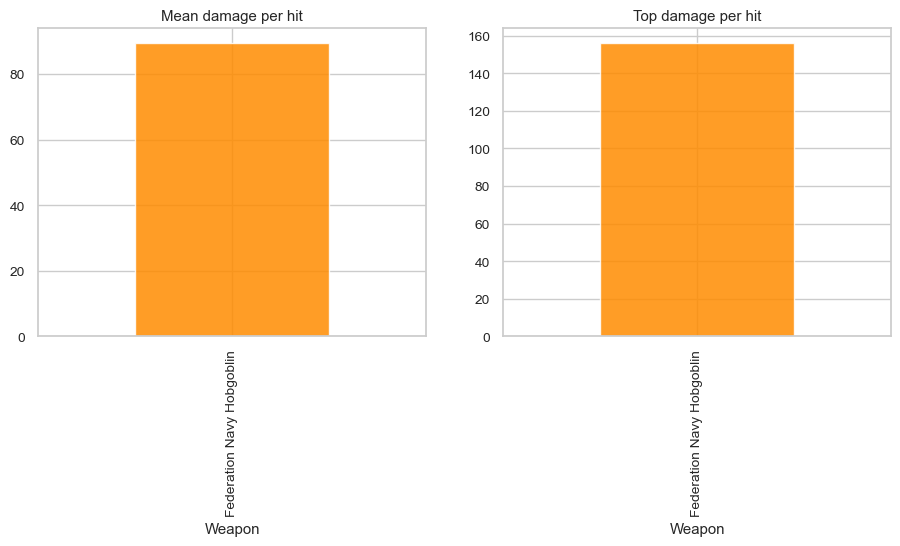

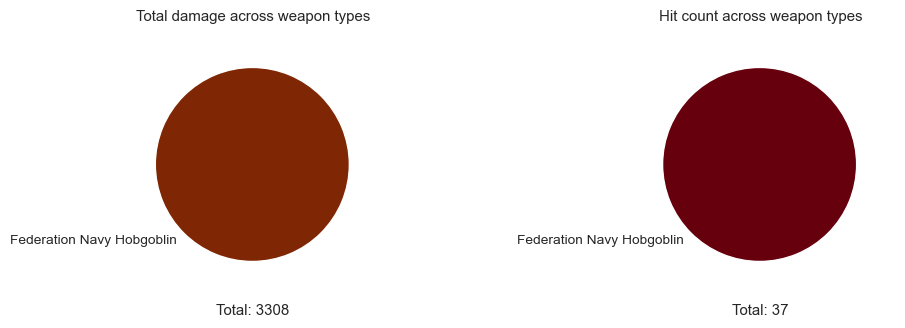

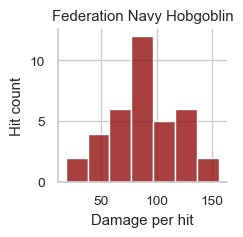



Performance on Centior Devourer:



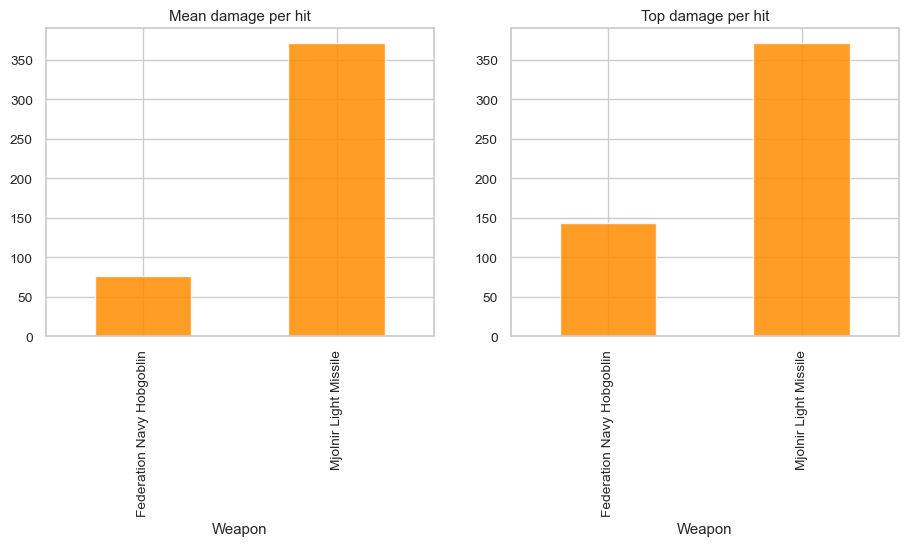

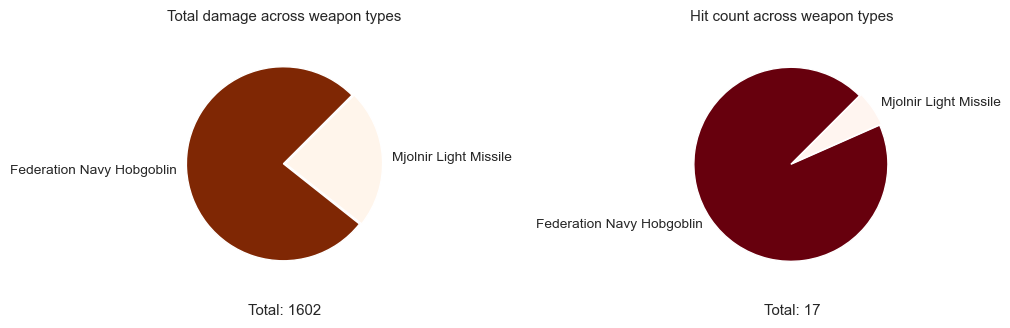

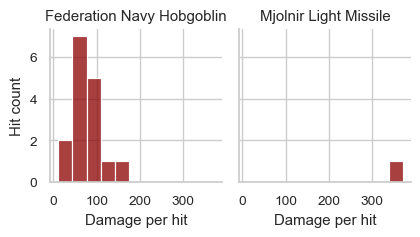



Performance on Centior Cannibal:



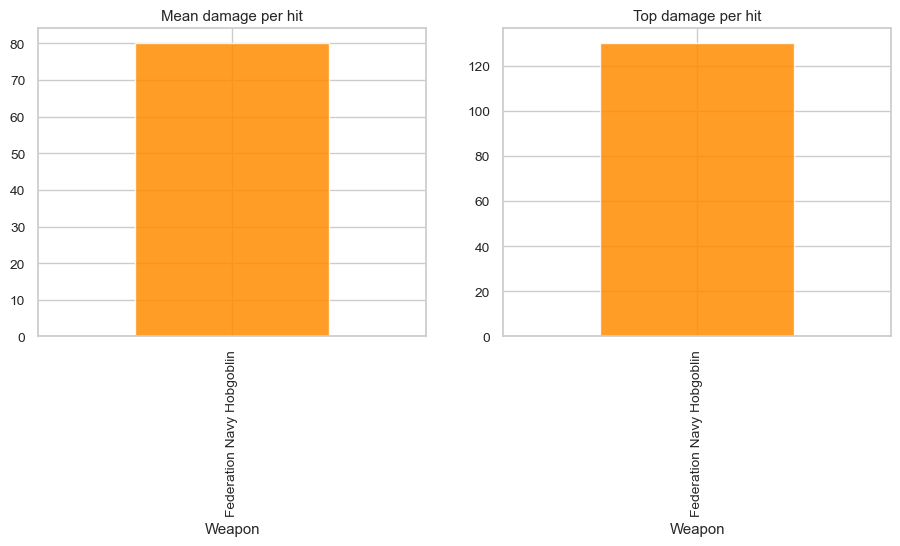

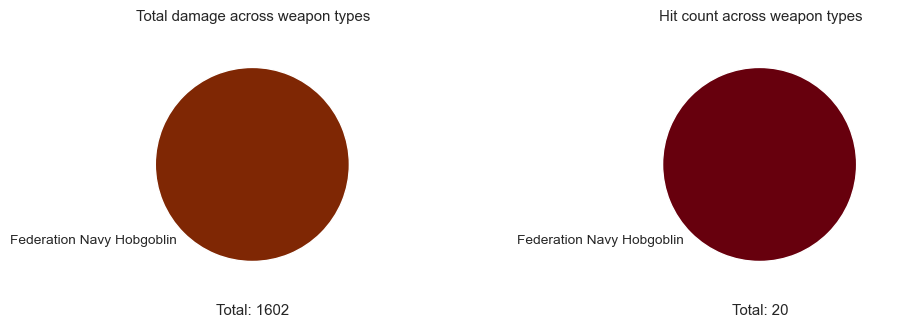

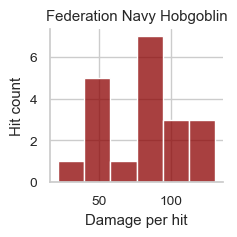



Performance on Centii Butcher:



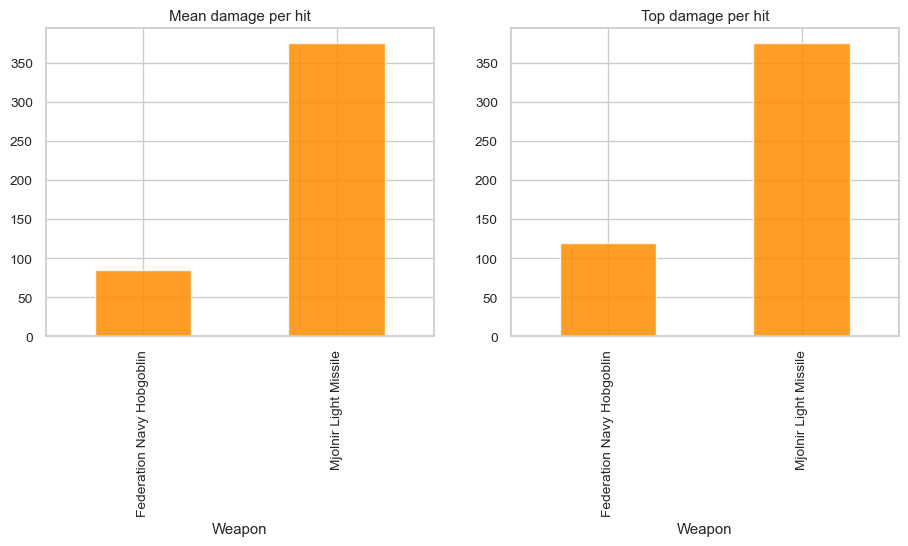

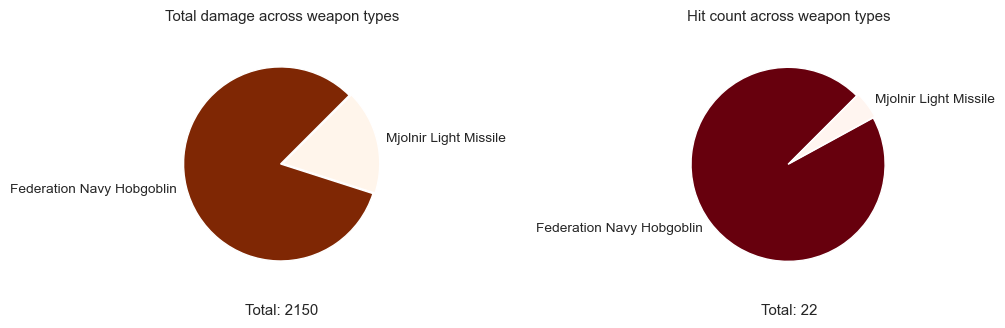

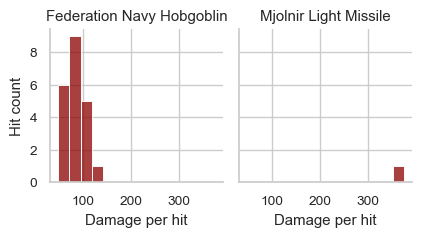



Performance on Centior Horror:



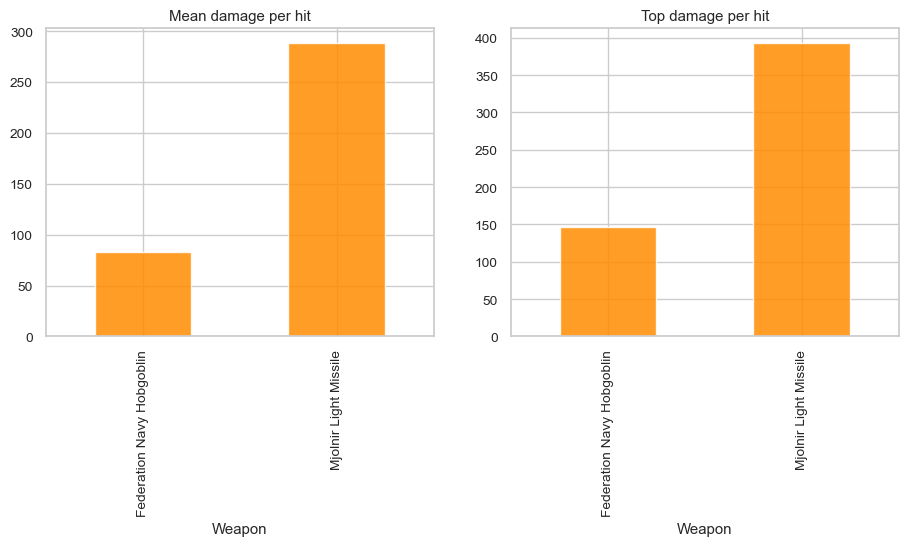

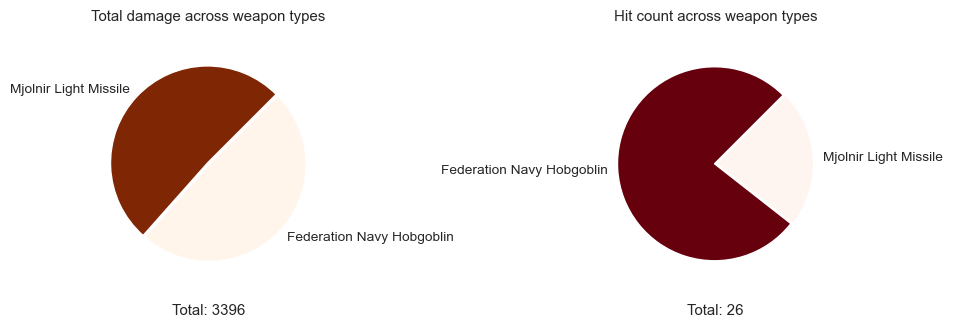

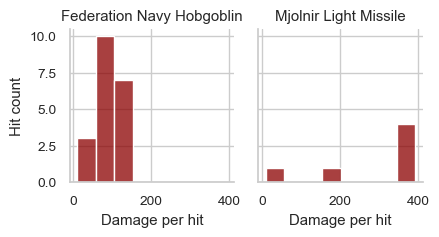



Performance on Centior Monster:



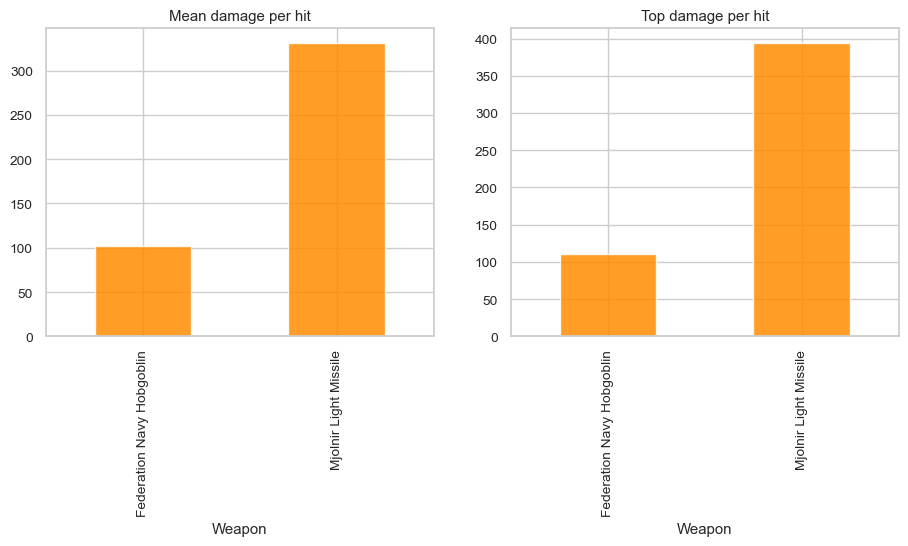

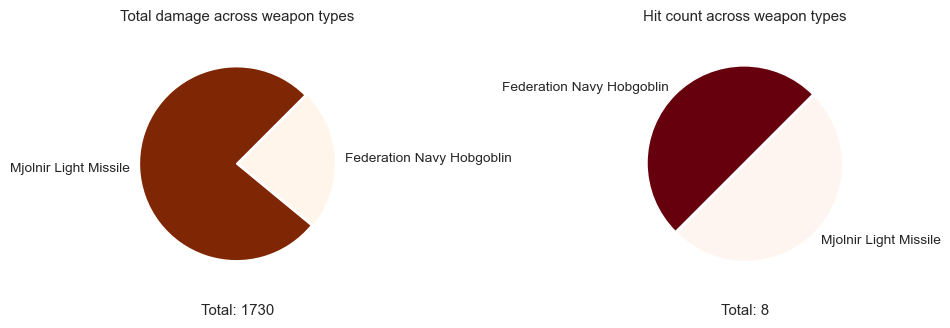

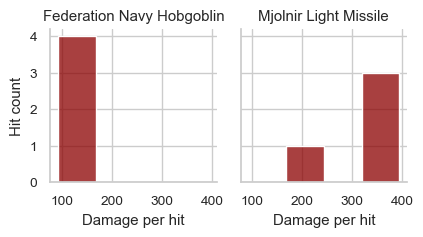



Performance on Centii Manslayer:



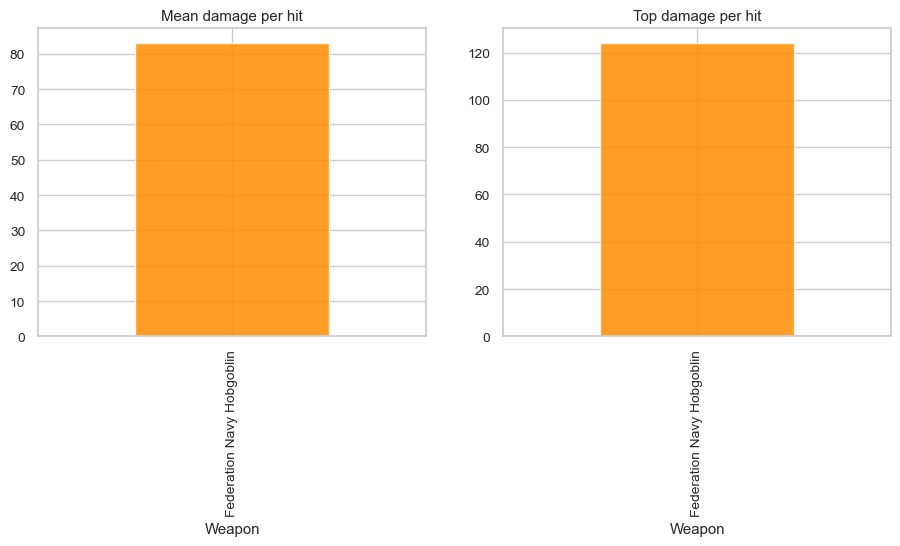

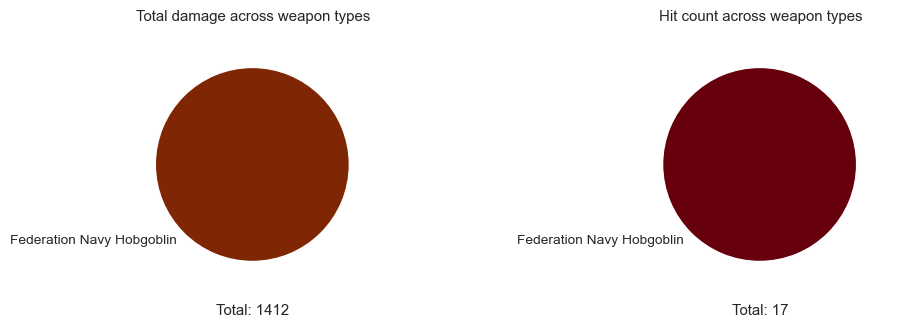

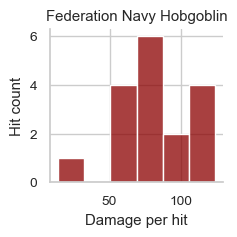



Performance on Centii Enslaver:



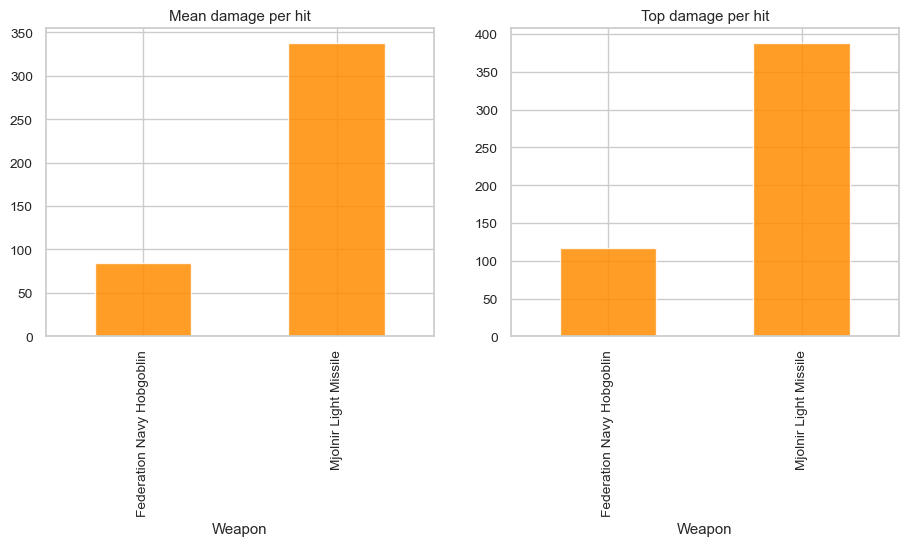

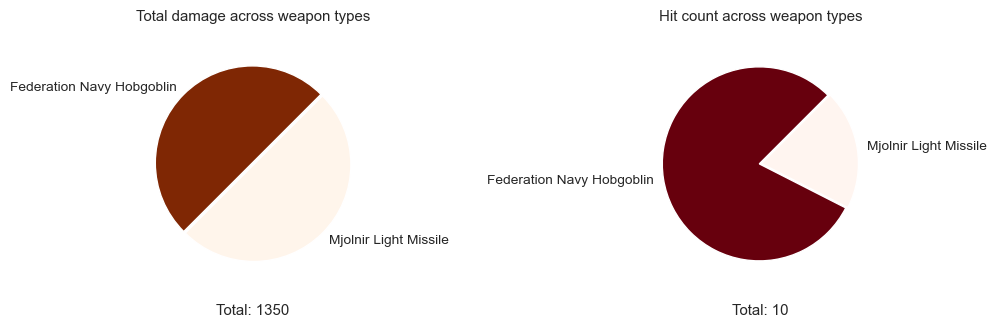

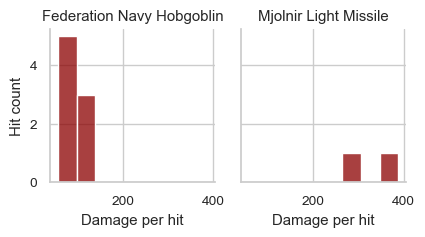



Performance on Centus Black Ops Agent:



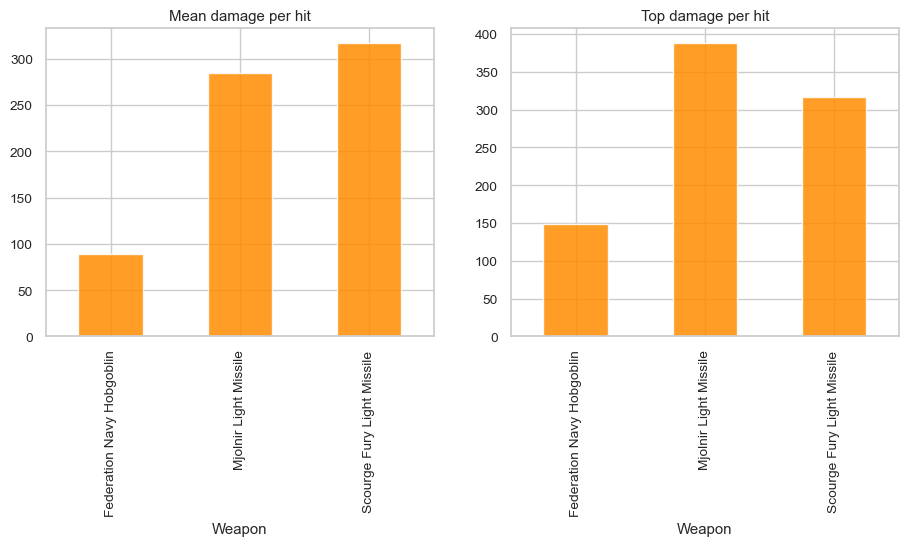

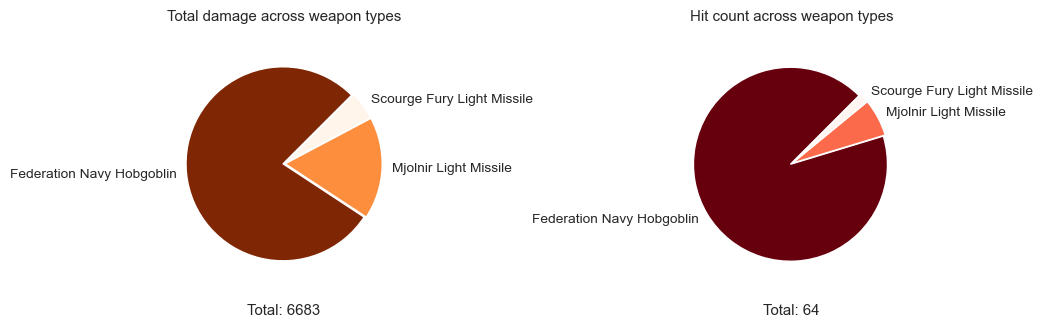

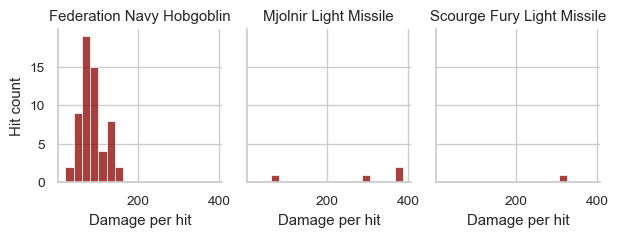



Performance on Sansha Black Ops Squad Leader:



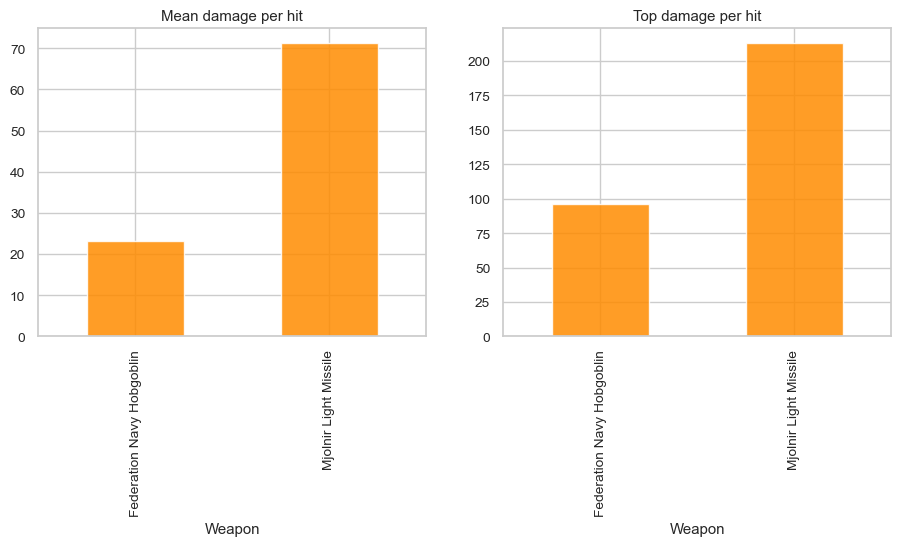

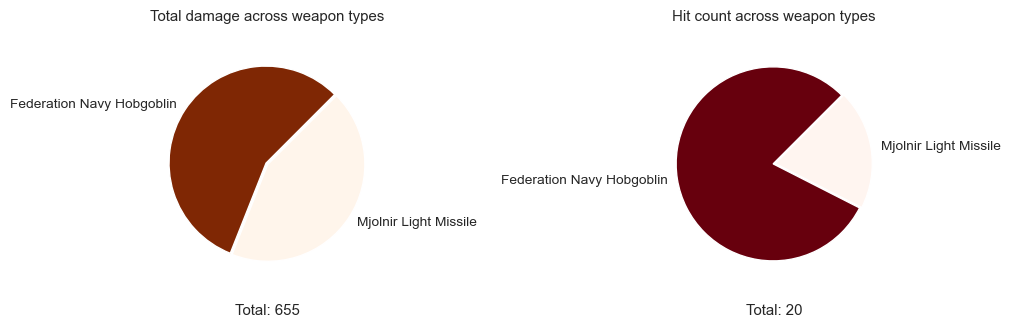

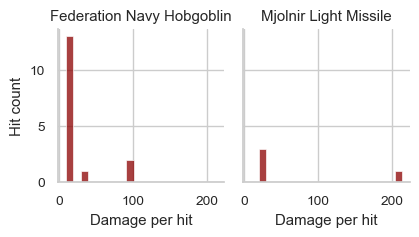



Performance on Centus Black Ops Assassin:



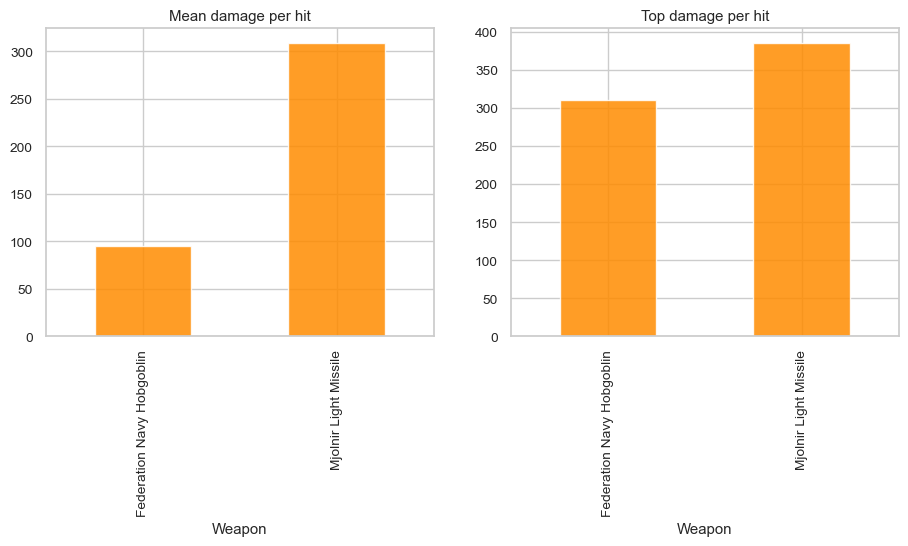

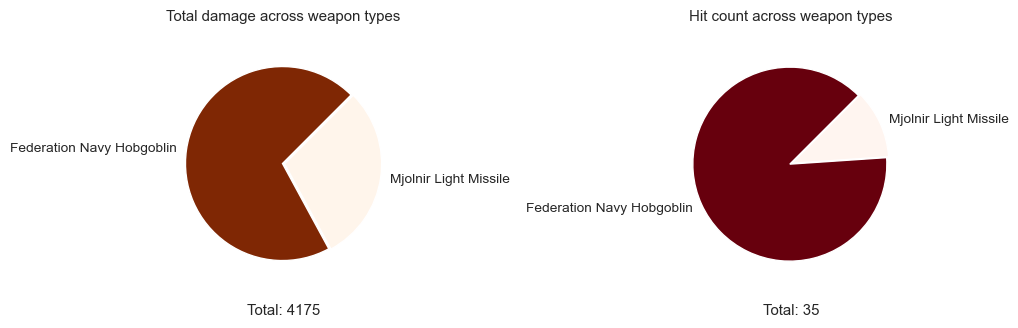

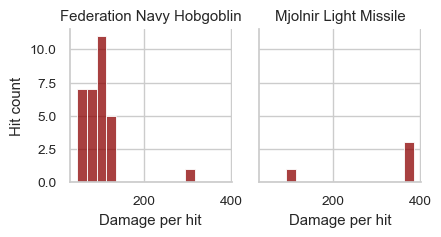



Performance on Sentry Gun:



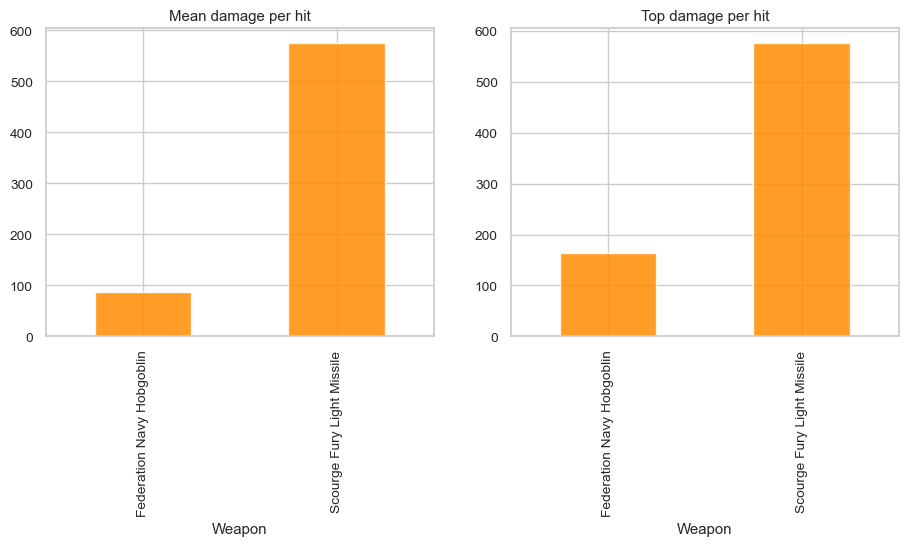

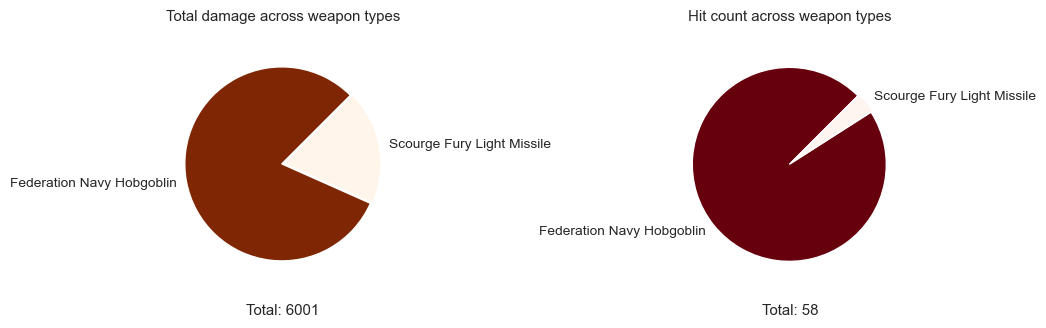

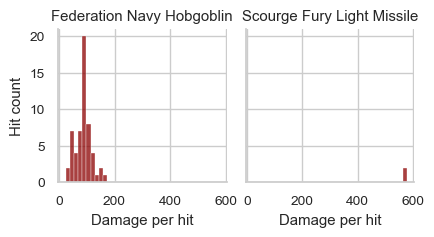



Performance on Centus Black Ops Veteran:



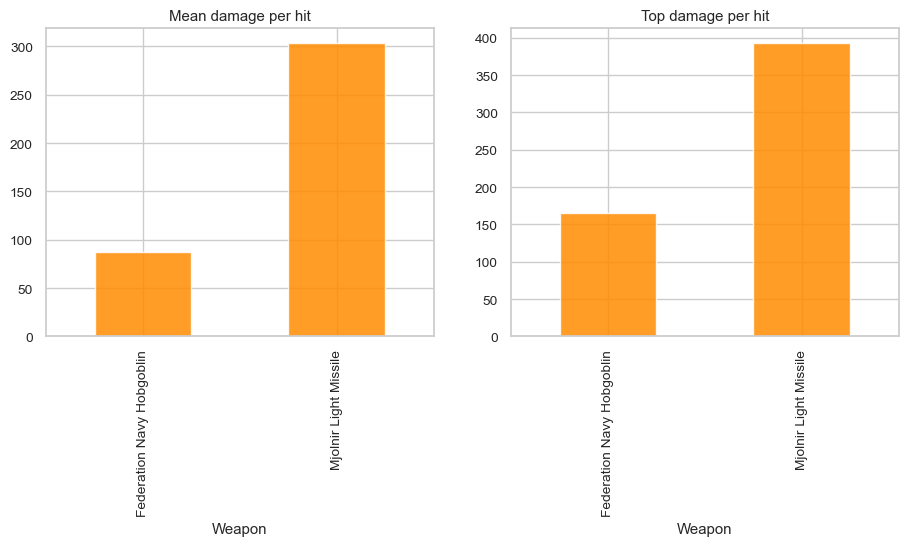

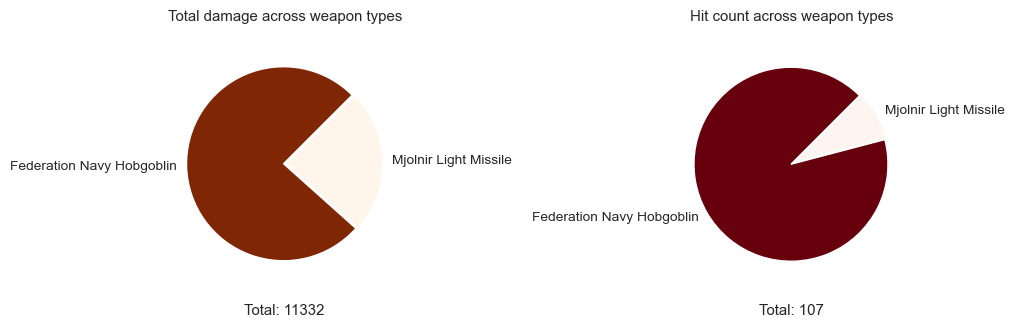

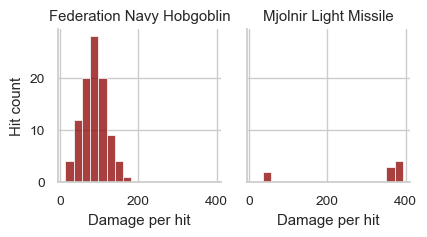



Performance on Centus Black Ops Commander:



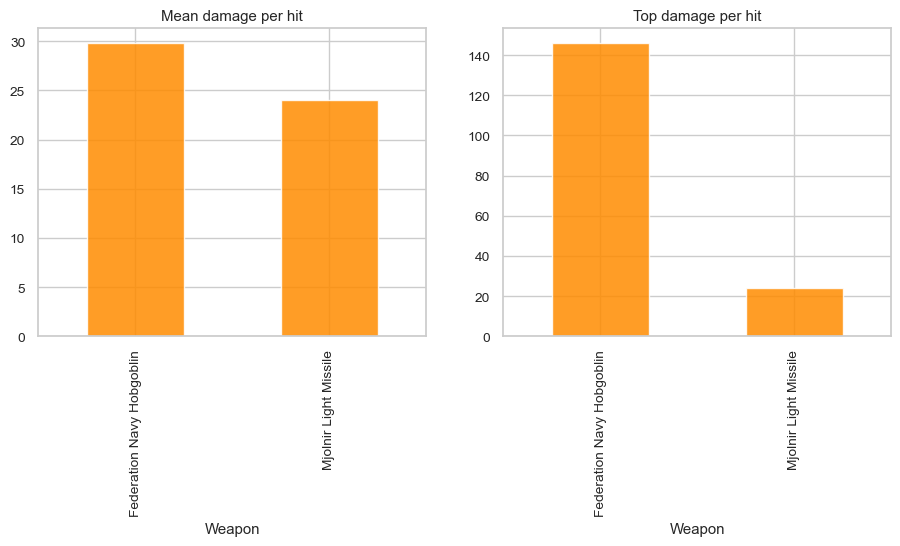

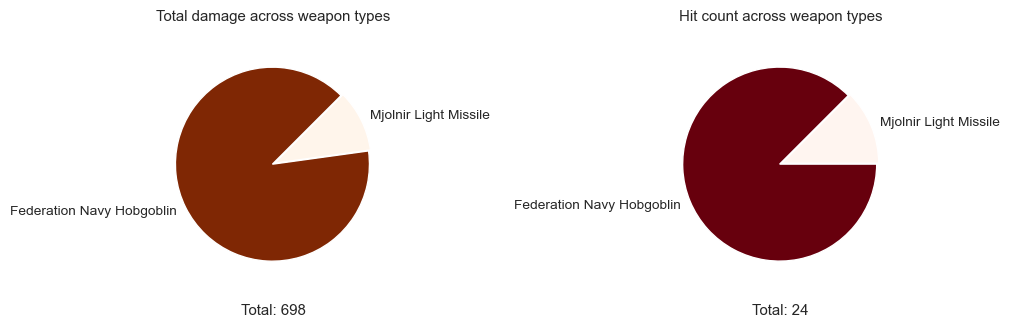

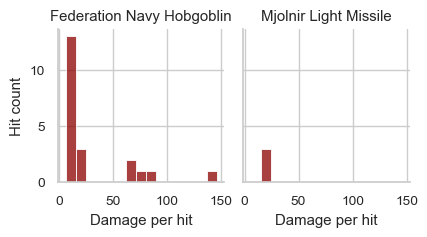



Performance on Sansha Heavy Missile Battery:



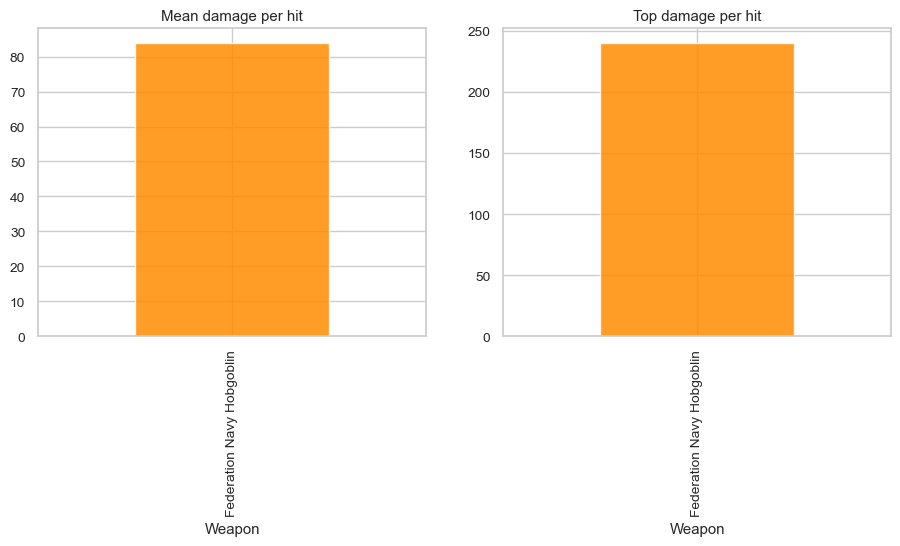

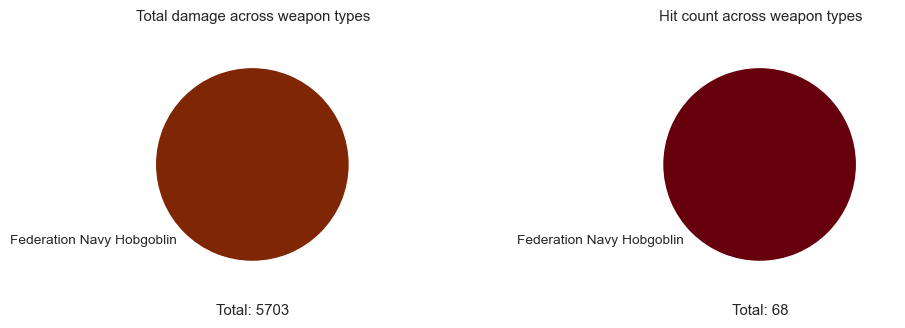

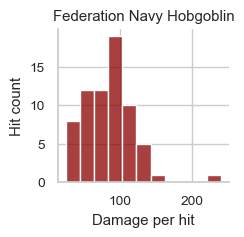



Performance on Sansha Sentry Gun:



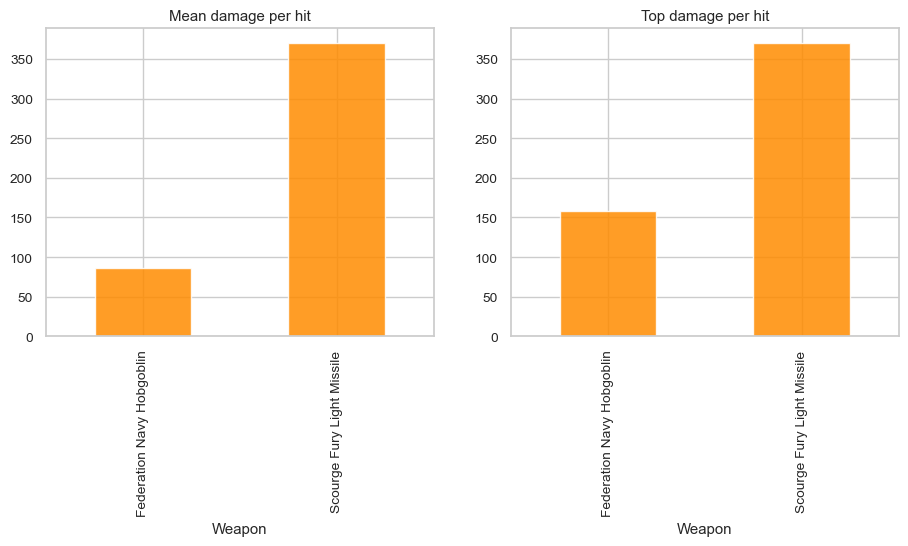

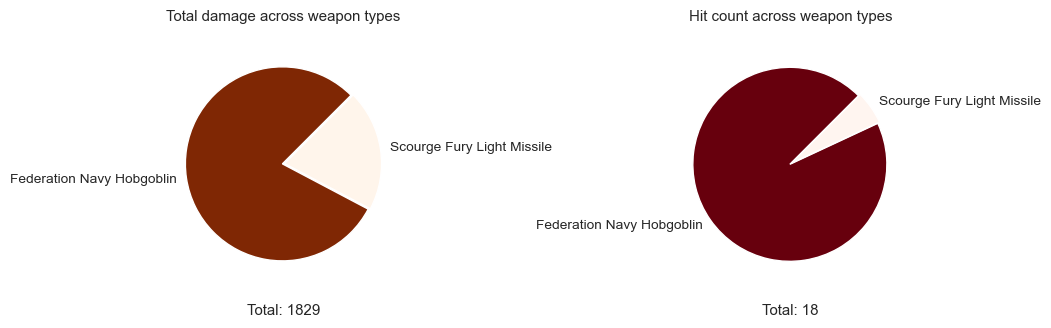

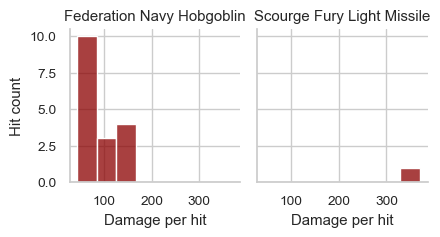

In [54]:
for target in targets:
    print(f'\nPerformance on {target}:', end='\n'*2)
    
    data_slice = dealt_df[dealt_df.Entity == target].sort_values(by='Weapon')
    
    if sum(totals_per_weapon) > 0:
        
        # mean and top damage barcharts
        plt.figure(figsize=(11,4)) 
        
        plt.subplot(121) #  plotting mean damage per hit per weapon 
        data_slice.groupby('Weapon').Damage.mean().plot(
            kind='bar', title='Mean damage per hit',
            ylabel='', 
            color='darkorange', alpha=.85
        )
        plt.subplot(122) #  plotting top damage per hit per weapon 
        data_slice.groupby('Weapon').Damage.max().plot(
            kind='bar', title='Top damage per hit', ylabel='', 
            color='darkorange', alpha=.85
        )      
        
        plt.show()
        
        # total damage and hit count pies
        totals_per_weapon = data_slice.groupby('Weapon').Damage.sum().sort_values(ascending=False)
        hits_per_weapon = data_slice.Weapon.value_counts().sort_values(ascending=False)
        
        plt.figure(figsize=(12,3.5), facecolor='white') 

        plt.subplot(121, #  plotting total damage across weapon types
                    xlabel=f'Total: {sum(totals_per_weapon)}')
        totals_per_weapon.plot(
            kind='pie', title='Total damage across weapon types',
            radius=.9,
            # center=(0,-5),
            cmap='Oranges_r',
            ylabel='', 
            startangle = 45,
            explode = pie_exploder(totals_per_weapon)
        )
        plt.subplot(122, #  plotting hit counts per weapon
                    xlabel=f'Total: {sum(hits_per_weapon)}') 
        hits_per_weapon.plot(
            kind='pie', title='Hit count across weapon types', ylabel='',
            cmap='Reds_r',
            radius=.9,
            startangle = 45,
            explode = pie_exploder(hits_per_weapon)
        )        
        
        plt.show()
        
        # damage per hit distributions across weapon systems
        g = sns.displot(
            data=data_slice, x="Damage", col="Weapon",
            col_wrap=5,
            height=2.5, aspect=.8, color='darkred'
        )
        g.set_axis_labels("Damage per hit", "Hit count")
        g.set_titles("{col_name}")
        plt.show()
        
        print()

    else:
        print('- Zero damage scored', end='\n'*2)
        continue